<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/ml_models_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns
from xgboost import XGBClassifier

In [80]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

In [ ]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [ ]:
# Feature Data

fa_cup_raw_features = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features WHERE season_year NOT IN ('21/22', '22/23')
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe().drop(columns=['season_year'])
display(fa_cup_raw_features_df)


all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)


,arena_stadium_capacity,home_team_league_level,home_win,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
0,41837,1,1,1,1,1,12,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
1,41837,1,1,1,1,1,12,1,1,1,...,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0
2,41837,1,1,1,1,1,12,1,1,1,...,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0
3,74879,1,1,1,1,1,12,1,1,1,...,71.20,0.000,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0
4,74879,1,0,2,3,7,4,6,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,<NA>,6,0,64,58,64,57,63,64,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
301,<NA>,6,0,64,58,64,57,63,64,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
302,9527,4,1,64,58,64,57,63,64,64,...,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1
303,6064,6,0,64,58,64,57,63,64,64,...,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0


,metric_id,metric


In [ ]:
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [67]:
# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}


In [82]:
def classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47):

  # Empty df for consolidating results
  all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
  fold_results = []

  # Define the ranking systems
  ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

  # Get all columns except the target and ranking columns
  target_variable = 'target_variable'
  base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

  # Identify numeric and categorical columns
  numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

  # Define preprocessing steps

  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', MinMaxScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  ranking_transformer = Pipeline(steps=[
      ('scaler', MinMaxScaler())
  ])

  # Define cross-validation strategy
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

  # Loop through each ranking system
  for ranking in ranking_systems:
      model_name_ranking = f"{model_name} {ranking}"
      print(model_name_ranking)

      if ranking == 'no_ranking':
          # Use all base features without ranking
          X = fa_cup_raw_features_df[base_features]
      else:
          # Include ranking features
          current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
          X = fa_cup_raw_features_df[current_features]

      y = fa_cup_raw_features_df['target_variable']

      # Initialize lists to store results for each fold of the model
      fold_accuracies = []
      fold_recalls = []
      confusion_matrices = []
      classification_reports = []
      all_y_true = []
      all_y_pred = []
      all_y_pred_proba = []  # Store probabilities for ROC

      # Perform cross-validation
      skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
      for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
          X_train, X_val = X.iloc[train_index], X.iloc[val_index]
          y_train, y_val = y.iloc[train_index], y.iloc[val_index]

           # Add home advantage if specified
          if home_advt == 'yes':
              X_train, home_advantage_column = add_home_advantage(X_train)
              X_val, _ = add_home_advantage(X_val)
              numeric_features = [home_advantage_column] + numeric_features

          # Update preprocessor
          if ranking == 'no_ranking':
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features)
                  ], verbose_feature_names_out=False)

          else:
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features),
                      ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                  ], verbose_feature_names_out=False)


          if weighted == 'yes':
             # Calculate weights using only training data
              weights = calculate_weights(y_train)

          # Create pipeline
          pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_classifier)
            ])

          # Create GridSearchCV object
          grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1)

          # Fit GridSearchCV
          grid_search.fit(X_train, y_train)

          # Get best model
          best_model = grid_search.best_estimator_

          # Print the best recall from GridSearchCV
          print(f"Best parameters: {grid_search.best_params_}")
          print(f"Best Estimator's Recall (from GridSearchCV): {grid_search.best_score_:.3f}")

          # Make predictions
          y_pred = best_model.predict(X_val)
          y_pred_proba = best_model.predict_proba(X_val)[:, 1] # Probabilities for the positive class and ROC curve/AUC Score

          # Calculate accuracy
          accuracy = accuracy_score(y_val, y_pred)
          fold_accuracies.append(accuracy)

          # Calculate recall
          recall = recall_score(y_val, y_pred)
          fold_recalls.append(recall)

          # Store fold results
          fold_results.append({
              'Model Name Ranking': model_name_ranking,
              'Fold': fold,
              'Best Parameters (GridSearchCV)': grid_search.best_params_,
              'Best Recall (GridSearchCV)': grid_search.best_score_,
              'Validation Accuracy': accuracy,
              'Validation Recall': recall
          })

          # Confusion matrix
          cm = confusion_matrix(y_val, y_pred)
          confusion_matrices.append(cm)

          # Generate classification report
          cr = classification_report(y_val, y_pred, output_dict=True)
          classification_reports.append(cr)

          # Store true and predicted values for later analysis
          all_y_true.extend(y_val)
          all_y_pred.extend(y_pred)
          all_y_pred_proba.extend(y_pred_proba)

          print(f"Fold {fold} Accuracy: {accuracy:.3f}")
          print(f"Fold {fold} Recall: {recall:.3f}")

      # Calculate average accuracy
      avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
      print(f"Average Accuracy: {avg_accuracy:.3f}")

      # Calculate average recall
      avg_recall = sum(fold_recalls) / len(fold_recalls)
      print(f"Average Recall: {avg_recall:.3f}")

      # Create and display results using existing function
      results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies, fold_recalls,  all_y_pred_proba, model_name_ranking)
      results_df = results_df.reset_index()
      results_df['metric_id'] = results_df.index + 1
      results_df = results_df[['metric_id', 'metric', model_name_ranking]]

      all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

      fold_results_df = pd.DataFrame(fold_results)

  return all_results_df, fold_results_df

In [ ]:
# Standard, no weights
model_name = "Standard LogisticRegression"
home_advt = 'no'
weighted = 'no'
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_slr = all_results_df
display(all_results_df_slr)

fold_results_df_slr = fold_results_df
display(fold_results_df_slr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slr.to_excel("all_slr_results.xlsx")
fold_results_df_slr.to_excel("fold_results_slr.xlsx")


In [ ]:
# Standard, no weights with home advantage
model_name = "Standard LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'no'
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_slrh = all_results_df
display(all_results_df_slrh)

fold_results_df_slrh = fold_results_df
display(fold_results_df_slrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slrh.to_excel("all_slrh_results.xlsx")
fold_results_df_slrh.to_excel("fold_results_slrh.xlsx")

Weighted LogisticRegression no_ranking
Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 1 Accuracy: 0.721
Fold 1 Recall: 0.625
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 2 Accuracy: 0.426
Fold 2 Recall: 0.562
Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.530
Fold 3 Accuracy: 0.639
Fold 3 Recall: 0.688
Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.553
Fold 4 Accuracy: 0.459
Fold 4 Recall: 0.353
Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.618
Fold 5

KeyboardInterrupt: 

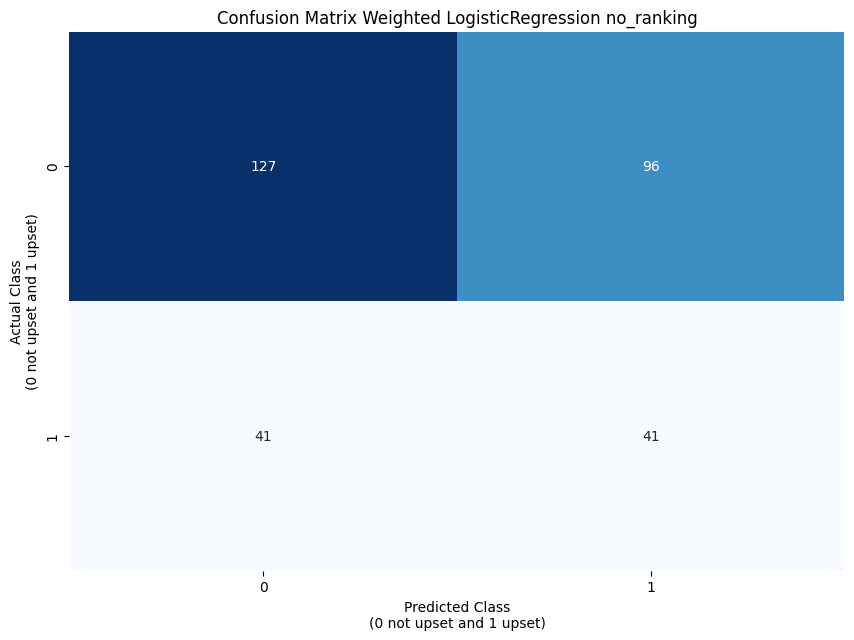

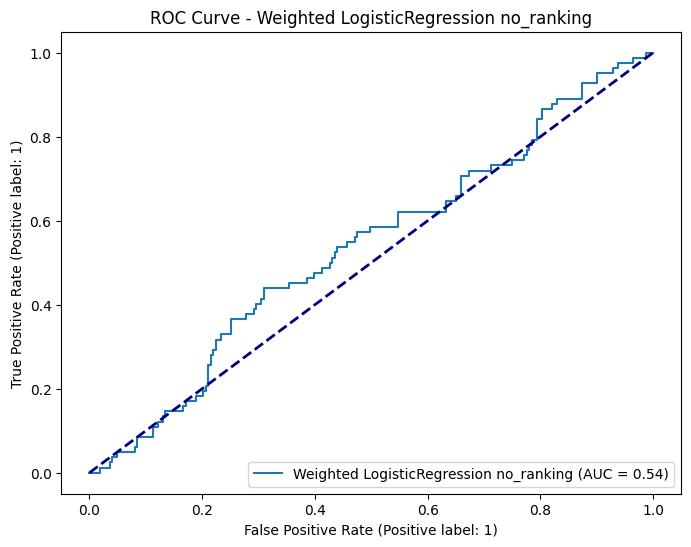

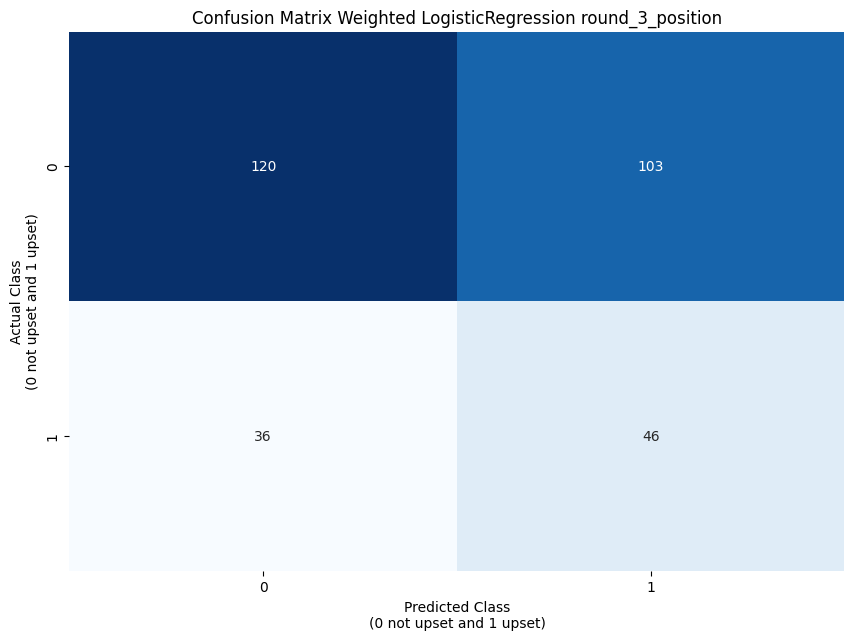

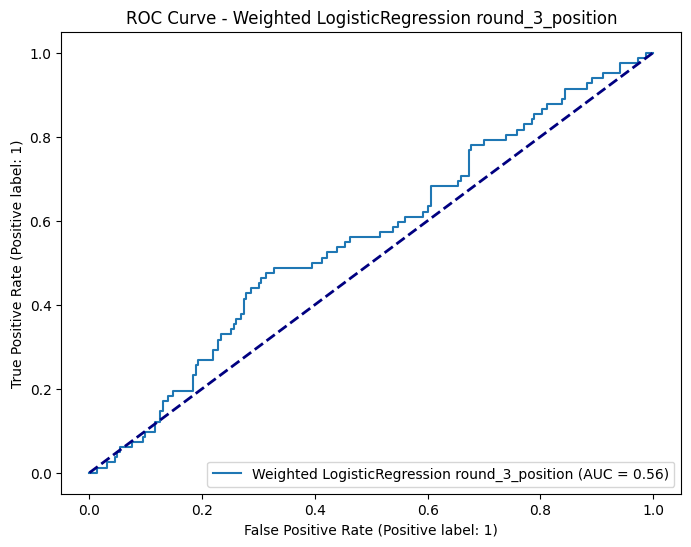

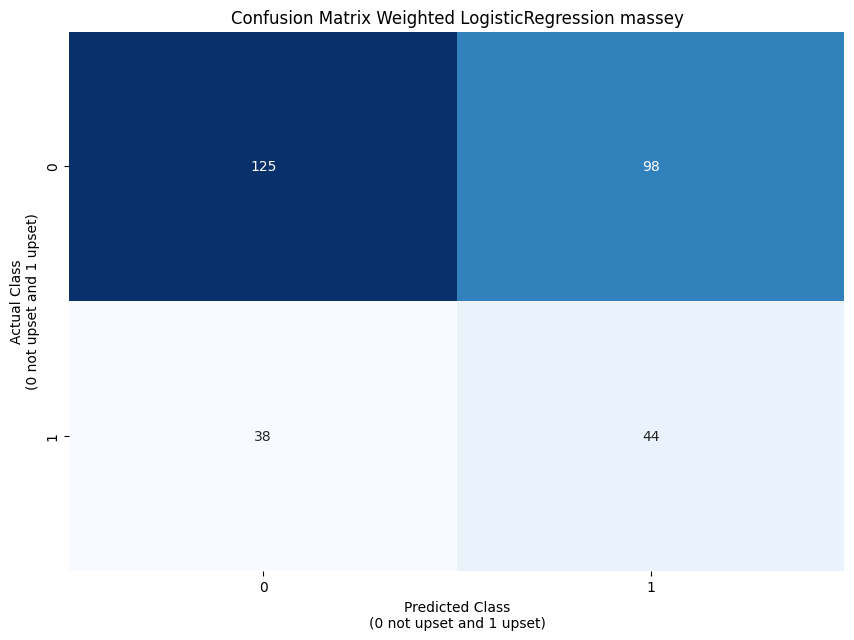

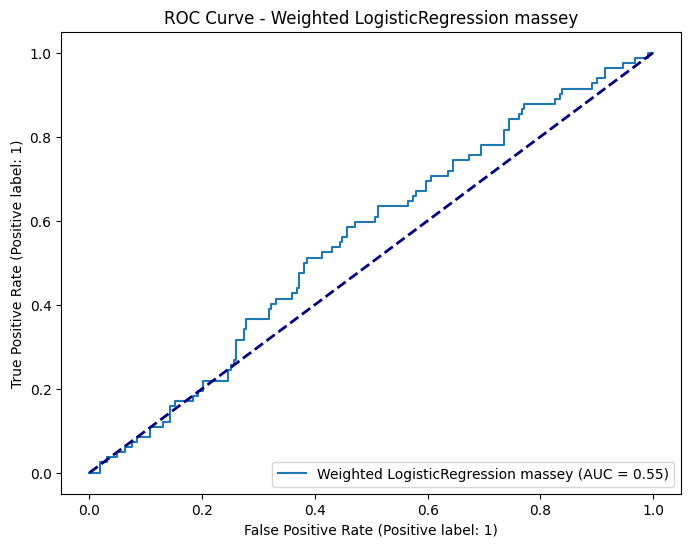

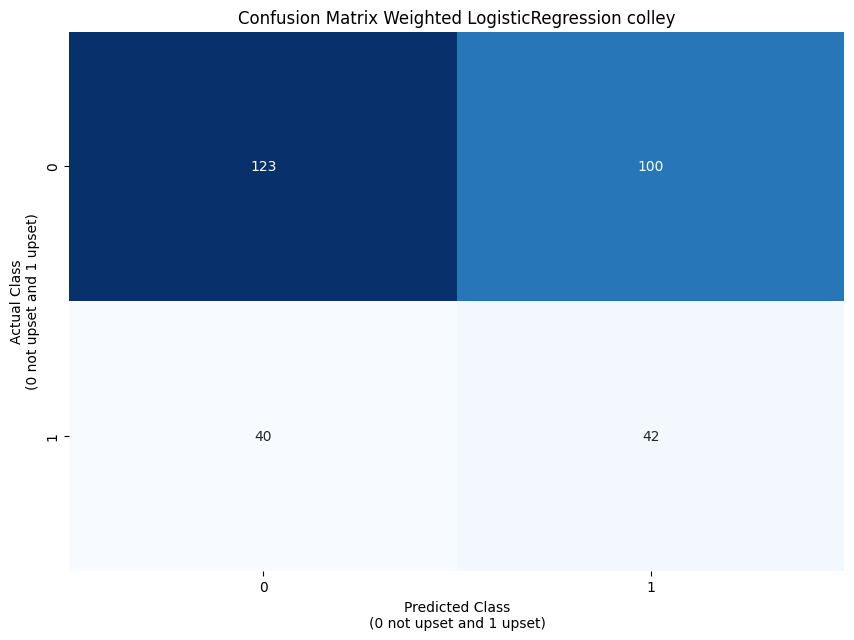

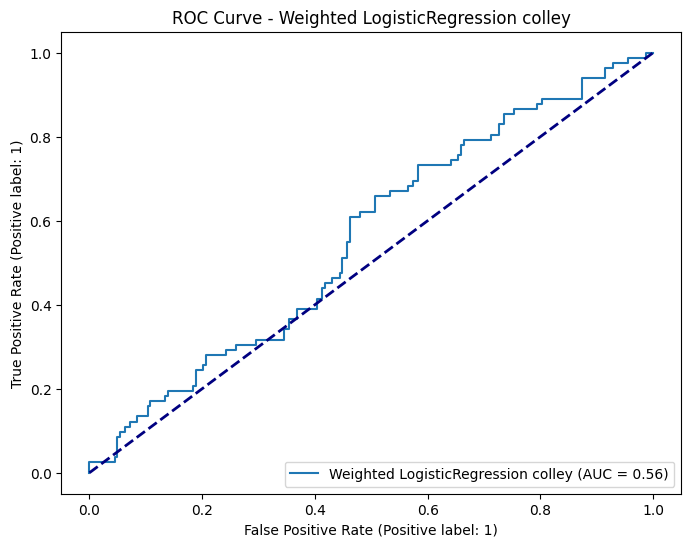

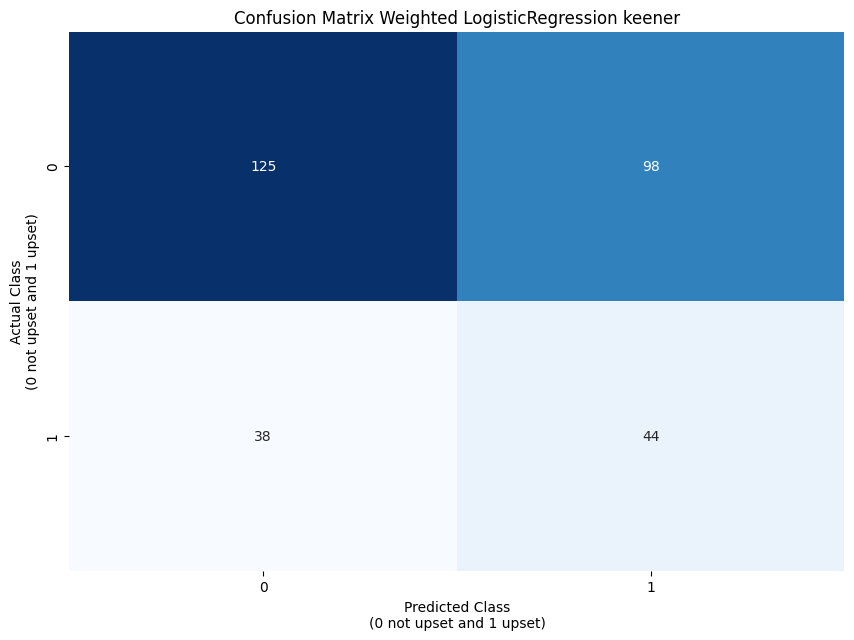

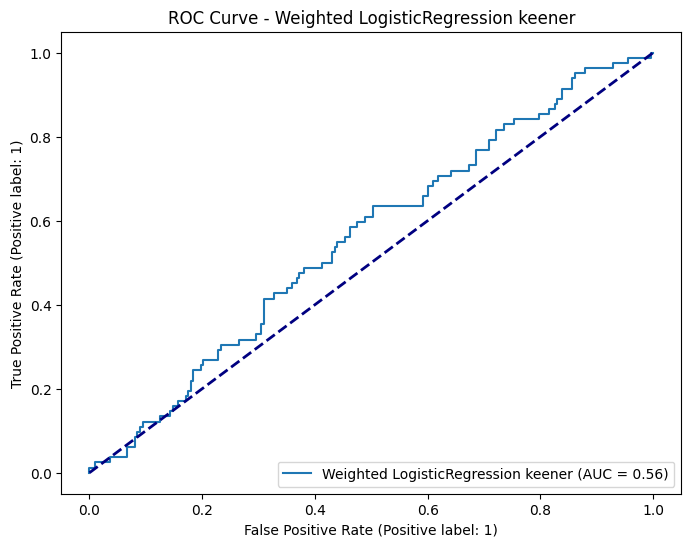

In [116]:
# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"
home_advt = 'no'
weighted = 'yes'
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_wlr = all_results_df
display(all_results_df_wlr)

fold_results_df_wlr = fold_results_df
display(fold_results_df_wlr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlr.to_excel("all_wlr_results.xlsx")
fold_results_df_wlr.to_excel("fold_results_wlr.xlsx")

In [ ]:
# Weighted Logistc Regression with home advatange
model_name = "Weighted LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'yes'
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_wlrh = all_results_df
display(all_results_df_wlrh)

fold_results_df_wlrh = fold_results_df
display(fold_results_df_wlrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlrh.to_excel("all_wlrh_results.xlsx")
fold_results_df_wlrh.to_excel("fold_results_wlrh.xlsx")

In [102]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
home_advt = 'no'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nn = all_results_df
display(all_results_df_nn)

fold_results_df_nn = fold_results_df
display(fold_results_df_nn)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nn.to_excel("all_nn_results.xlsx")
fold_results_df_nn.to_excel("fold_results_nn.xlsx")

,metric_id,metric,MLP Classifier Neural Network no_ranking,MLP Classifier Neural Network round_3_position,MLP Classifier Neural Network massey,MLP Classifier Neural Network colley,MLP Classifier Neural Network keener,MLP Classifier Neural Network trueskill,MLP Classifier Neural Network borda_count,MLP Classifier Neural Network local_kemeny_optimisation
0,1,Cross-validation Accuracy Mean,0.964,0.892,0.869,0.869,0.925,0.908,0.879,0.918
1,2,Cross-validation Accuracy Standard Deviation,0.035,0.153,0.116,0.115,0.102,0.094,0.122,0.099
2,3,Cross-validation Recall Mean,0.926,0.914,0.527,0.540,0.738,0.701,0.564,0.739
3,4,Cross-validation Recall Standard Deviation,0.035,0.153,0.116,0.115,0.102,0.094,0.122,0.099
4,5,Overall Accuracy,0.964,0.892,0.869,0.869,0.925,0.908,0.879,0.918
5,6,Confusion Matrix - True Negative (Class 0),218.000,197.000,222.000,221.000,222.000,220.000,222.000,220.000
6,7,Confusion Matrix - False Positive (Class 1),5.000,26.000,1.000,2.000,1.000,3.000,1.000,3.000
7,8,Confusion Matrix - False Negative (Class 0),6.000,7.000,39.000,38.000,22.000,25.000,36.000,22.000
8,9,Confusion Matrix - True Positive (Class 1),76.000,75.000,43.000,44.000,60.000,57.000,46.000,60.000
9,10,Precision (Class 0),0.973,0.966,0.851,0.853,0.910,0.898,0.860,0.909


MLP Classifier Neural Network with home advantage no_ranking
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.712
Fold 1 Accuracy: 0.967
Fold 1 Recall: 0.938
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.758
Fold 2 Accuracy: 0.984
Fold 2 Recall: 0.938
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.621
Fold 3 Accuracy: 0.918
Fold 3 Recall: 0.750
Best parameters: {'classifier__activation': 'logistic', 'c

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.667
Fold 1 Accuracy: 0.738
Fold 1 Recall: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.712
Fold 2 Accuracy: 0.967
Fold 2 Recall: 0.938
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.712
Fold 3 Accuracy: 0.885
Fold 3 Recall: 0.625
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.665
Fold 4 Accuracy: 0.951
Fold 4 Recall: 0.824
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10,), 'classifier__learn

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 3 Accuracy: 0.738
Fold 3 Recall: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.734
Fold 4 Accuracy: 0.721
Fold 4 Recall: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.694
Fold 5 Accuracy: 0.934
Fold 5 Recall: 0.882
Average Accuracy: 0.813
Average Recall: 0.339
MLP Classifier Neural Network with home advantage keener
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.667
Fold 1 Accuracy: 0.951
Fold 1 Recall: 0.875
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.667
Fold 2 Accuracy: 0.984
Fold 2 Recall: 0.938
Best parameters: {

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.682
Fold 2 Accuracy: 0.984
Fold 2 Recall: 0.938
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.606
Fold 3 Accuracy: 0.885
Fold 3 Recall: 0.562
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.665
Fold 4 Accuracy: 0.951
Fold 4 Recall: 0.882
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifie

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.664
Fold 5 Accuracy: 0.902
Fold 5 Recall: 0.765
Average Accuracy: 0.889
Average Recall: 0.640
MLP Classifier Neural Network with home advantage local_kemeny_optimisation
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.636
Fold 1 Accuracy: 0.918
Fold 1 Recall: 0.812
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.697
Fold 2 Accuracy: 0.984
Fold 2 Recall: 1.

,metric_id,metric,MLP Classifier Neural Network with home advantage no_ranking,MLP Classifier Neural Network with home advantage round_3_position,MLP Classifier Neural Network with home advantage massey,MLP Classifier Neural Network with home advantage colley,MLP Classifier Neural Network with home advantage keener,MLP Classifier Neural Network with home advantage trueskill,MLP Classifier Neural Network with home advantage borda_count,MLP Classifier Neural Network with home advantage local_kemeny_optimisation
0,1,Cross-validation Accuracy Mean,0.911,0.892,0.885,0.813,0.918,0.895,0.889,0.921
1,2,Cross-validation Accuracy Standard Deviation,0.098,0.082,0.065,0.099,0.059,0.085,0.086,0.042
2,3,Cross-validation Recall Mean,0.701,0.630,0.672,0.339,0.793,0.641,0.640,0.807
3,4,Cross-validation Recall Standard Deviation,0.098,0.082,0.065,0.099,0.059,0.085,0.086,0.042
4,5,Overall Accuracy,0.911,0.892,0.885,0.813,0.918,0.895,0.889,0.921
5,6,Confusion Matrix - True Negative (Class 0),221.000,220.000,215.000,220.000,215.000,220.000,219.000,215.000
6,7,Confusion Matrix - False Positive (Class 1),2.000,3.000,8.000,3.000,8.000,3.000,4.000,8.000
7,8,Confusion Matrix - False Negative (Class 0),25.000,30.000,27.000,54.000,17.000,29.000,30.000,16.000
8,9,Confusion Matrix - True Positive (Class 1),57.000,52.000,55.000,28.000,65.000,53.000,52.000,66.000
9,10,Precision (Class 0),0.898,0.880,0.888,0.803,0.927,0.884,0.880,0.931


,Model Name Ranking,Fold,Best Parameters (GridSearchCV),Best Recall (GridSearchCV),Validation Accuracy,Validation Recall
0,MLP Classifier Neural Network with home advant...,1,"{'classifier__activation': 'logistic', 'classi...",0.712121,0.967213,0.937500
1,MLP Classifier Neural Network with home advant...,2,"{'classifier__activation': 'relu', 'classifier...",0.757576,0.983607,0.937500
2,MLP Classifier Neural Network with home advant...,3,"{'classifier__activation': 'logistic', 'classi...",0.621212,0.918033,0.750000
3,MLP Classifier Neural Network with home advant...,4,"{'classifier__activation': 'logistic', 'classi...",0.678211,0.967213,0.882353
4,MLP Classifier Neural Network with home advant...,5,"{'classifier__activation': 'logistic', 'classi...",0.770563,0.721311,0.000000
5,MLP Classifier Neural Network with home advant...,1,"{'classifier__activation': 'logistic', 'classi...",0.666667,0.737705,0.000000
6,MLP Classifier Neural Network with home advant...,2,"{'classifier__activation': 'tanh', 'classifier...",0.712121,0.967213,0.937500
7,MLP Classifier Neural Network with home advant...,3,"{'classifier__activation': 'relu', 'classifier...",0.712121,0.885246,0.625000
8,MLP Classifier Neural Network with home advant...,4,"{'classifier__activation': 'relu', 'classifier...",0.664502,0.950820,0.823529
9,MLP Classifier Neural Network with home advant...,5,"{'classifier__activation': 'tanh', 'classifier...",0.678932,0.918033,0.764706


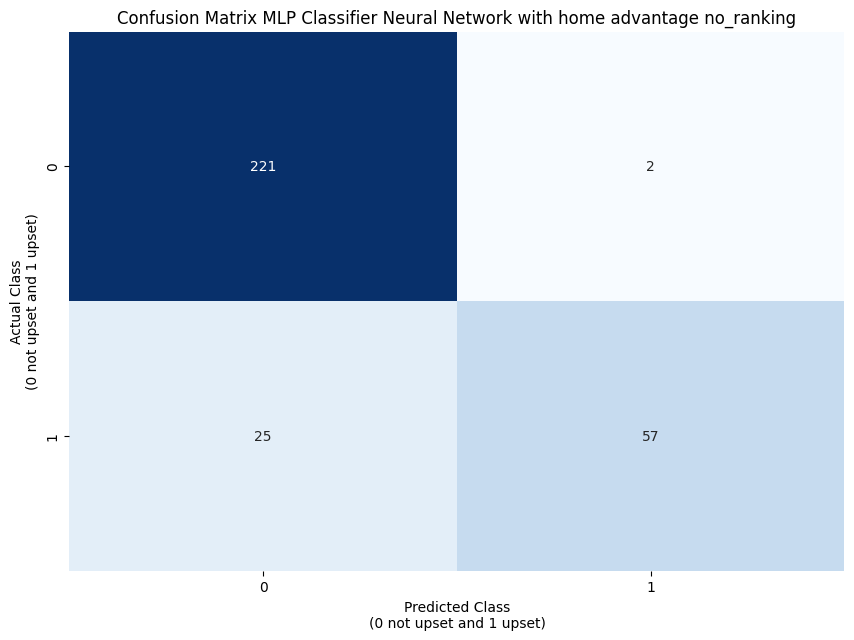

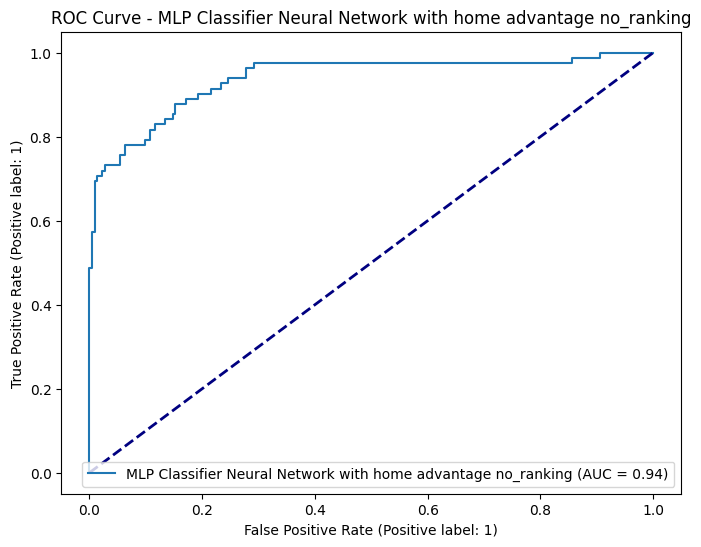

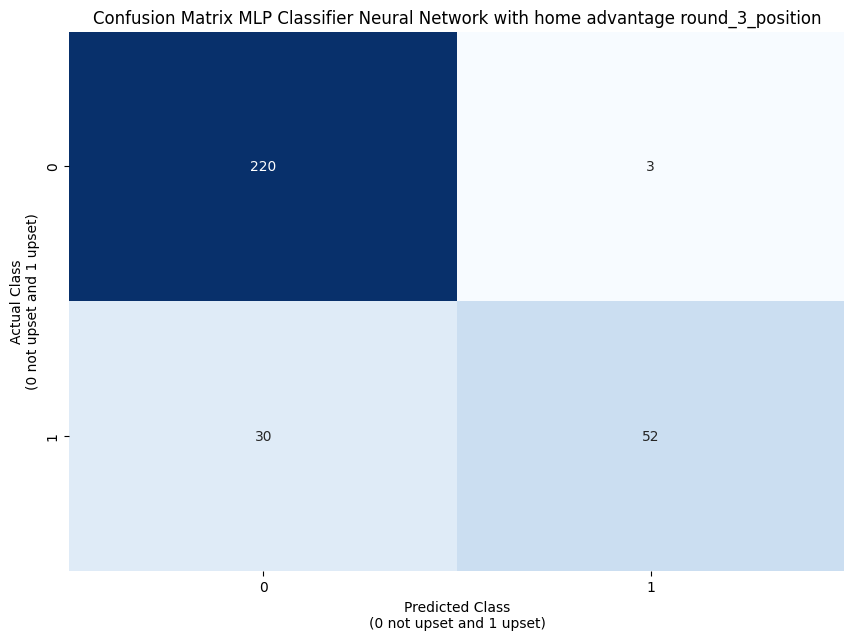

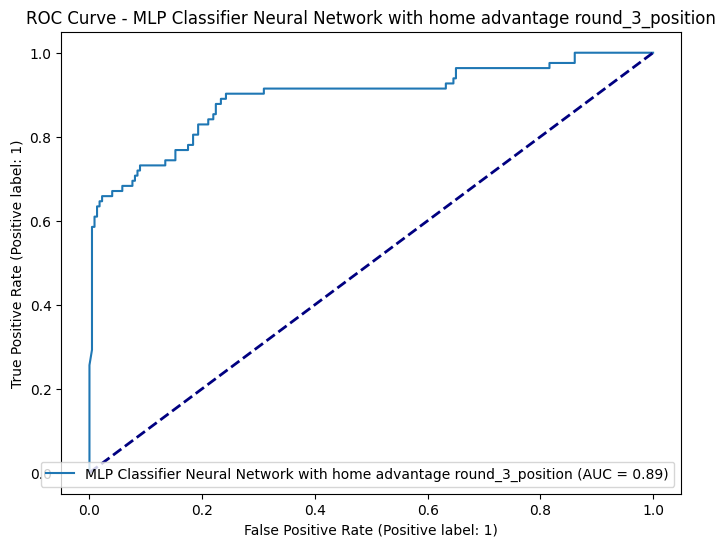

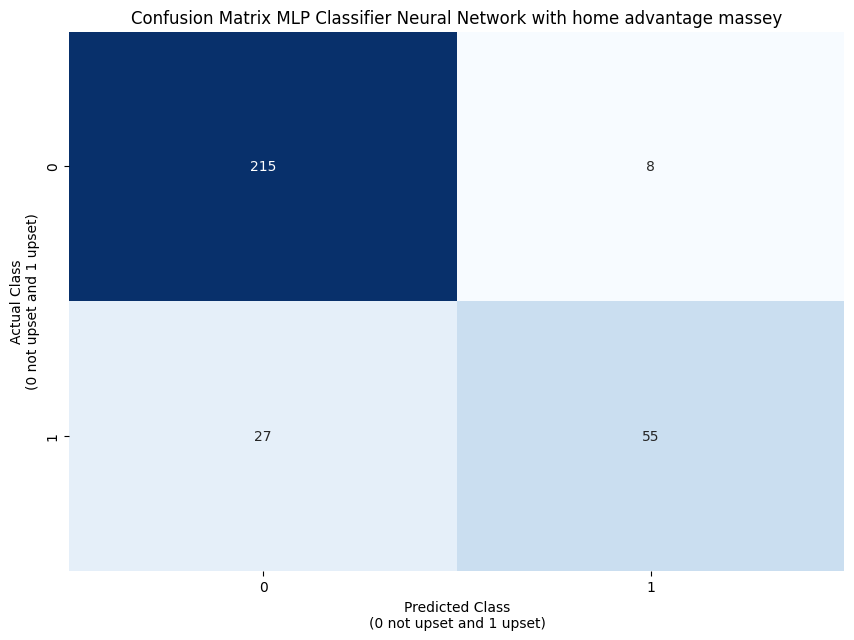

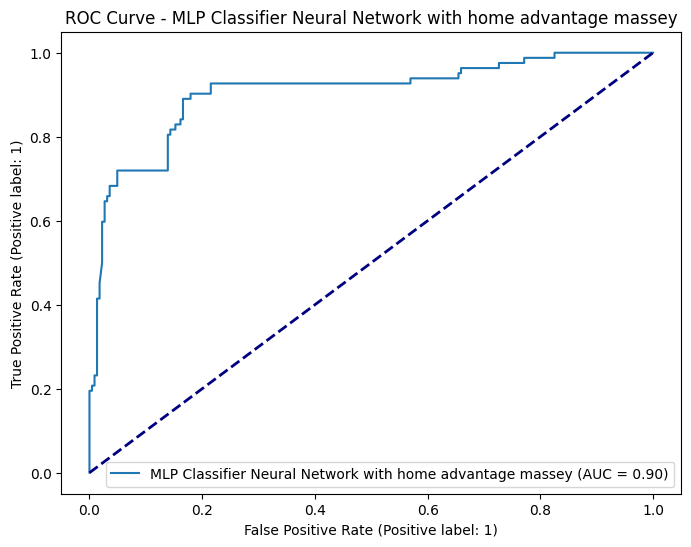

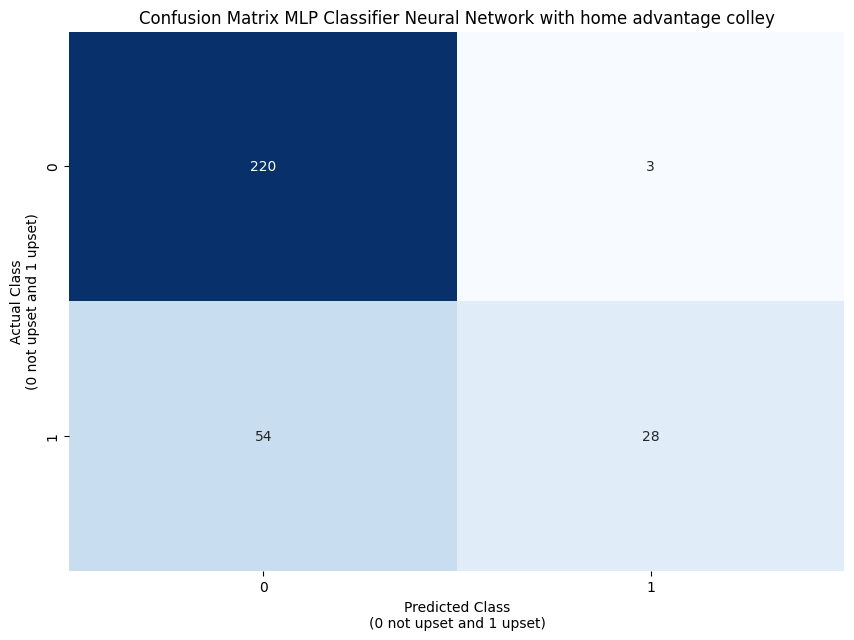

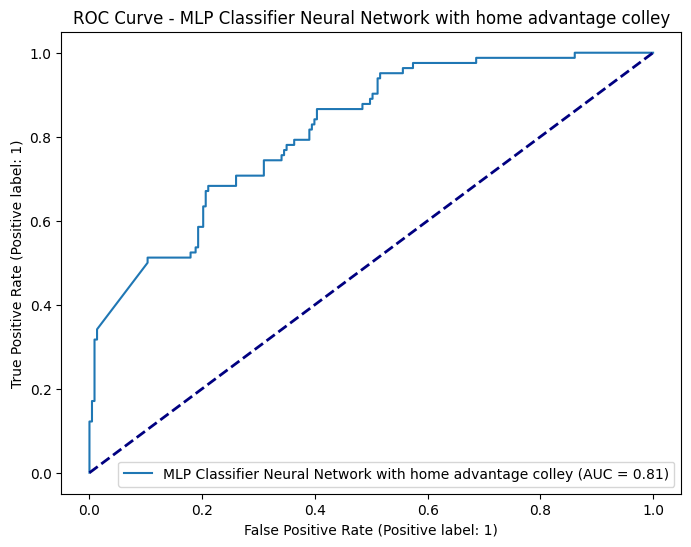

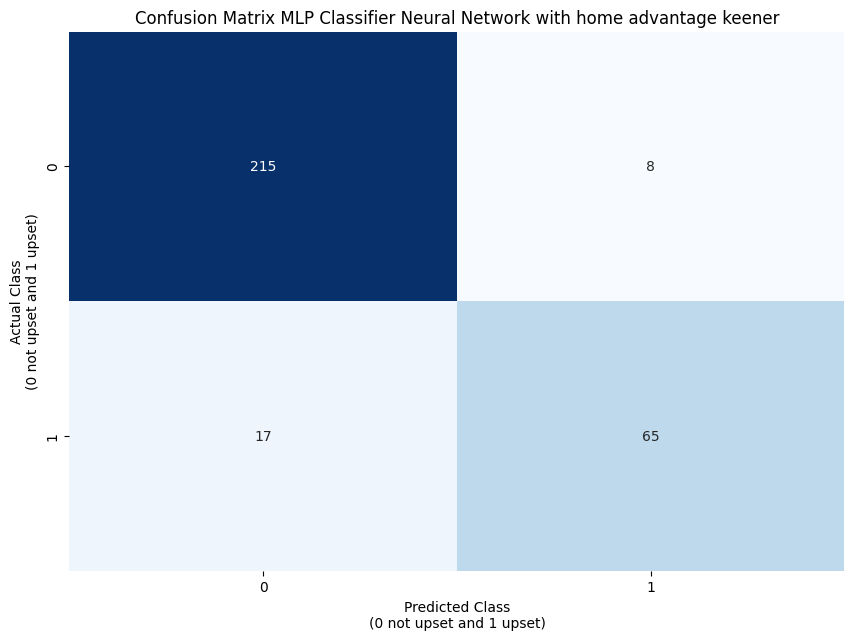

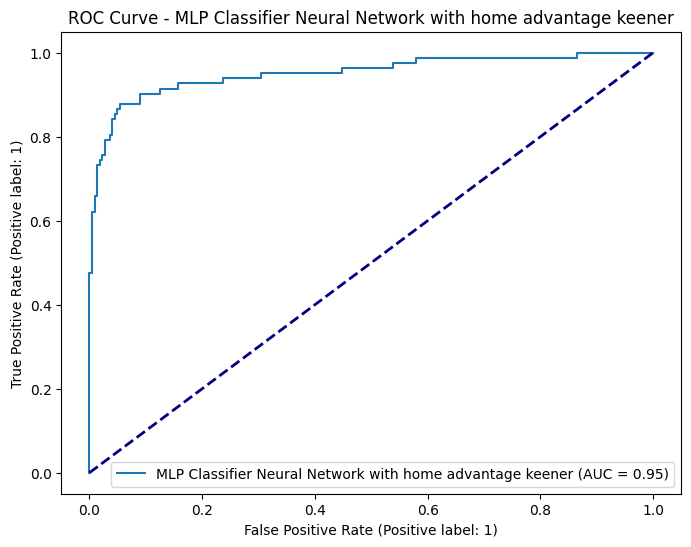

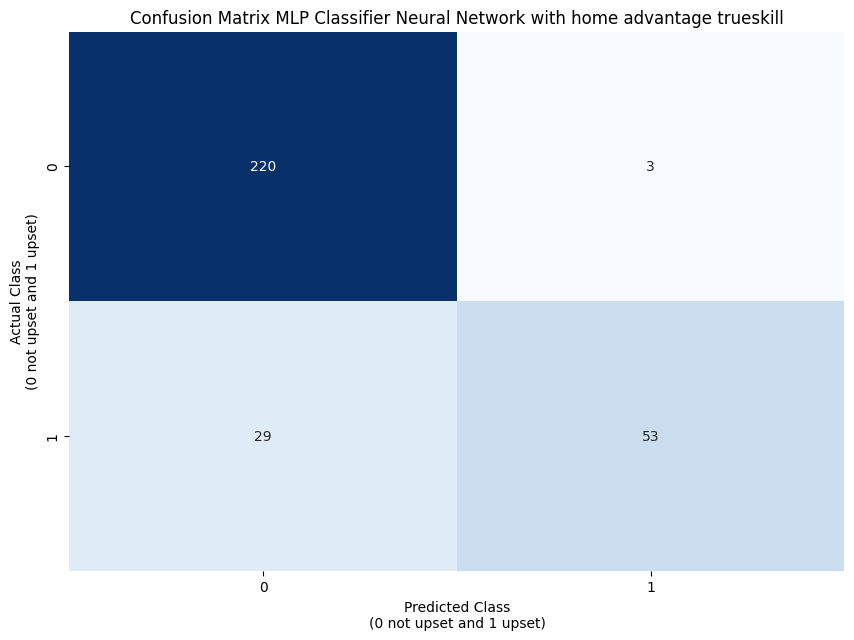

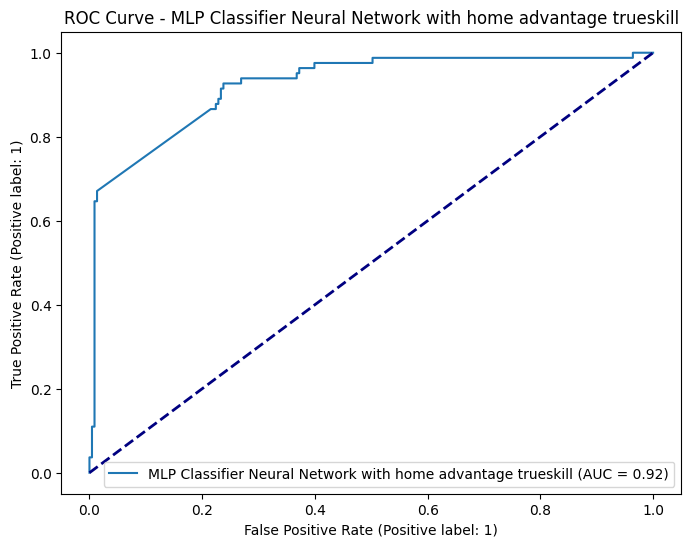

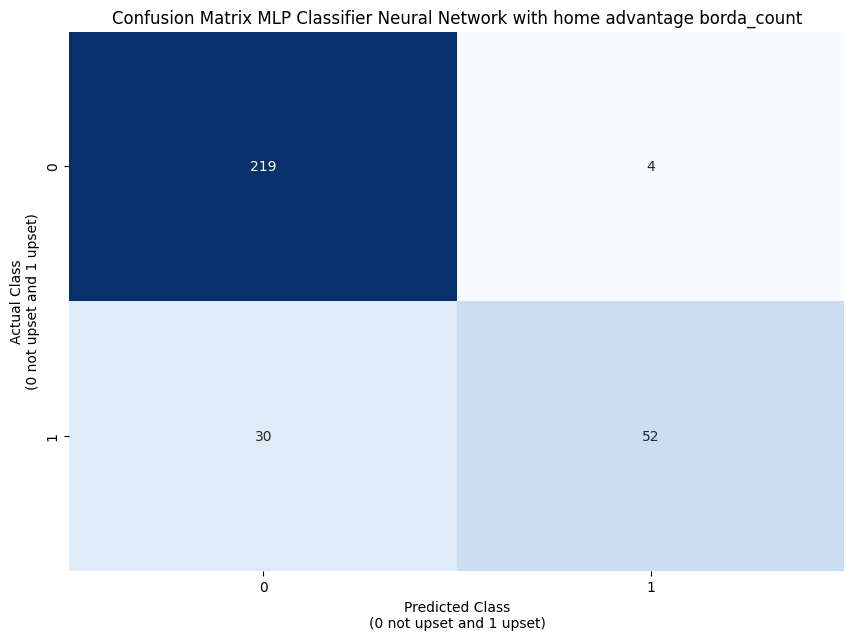

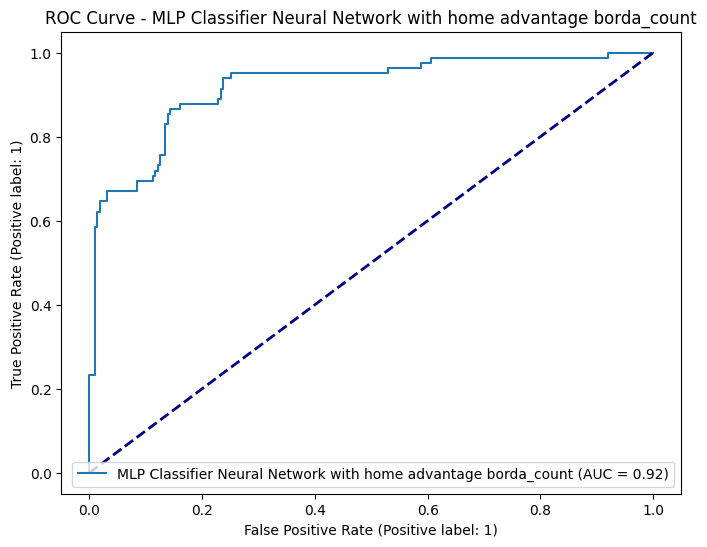

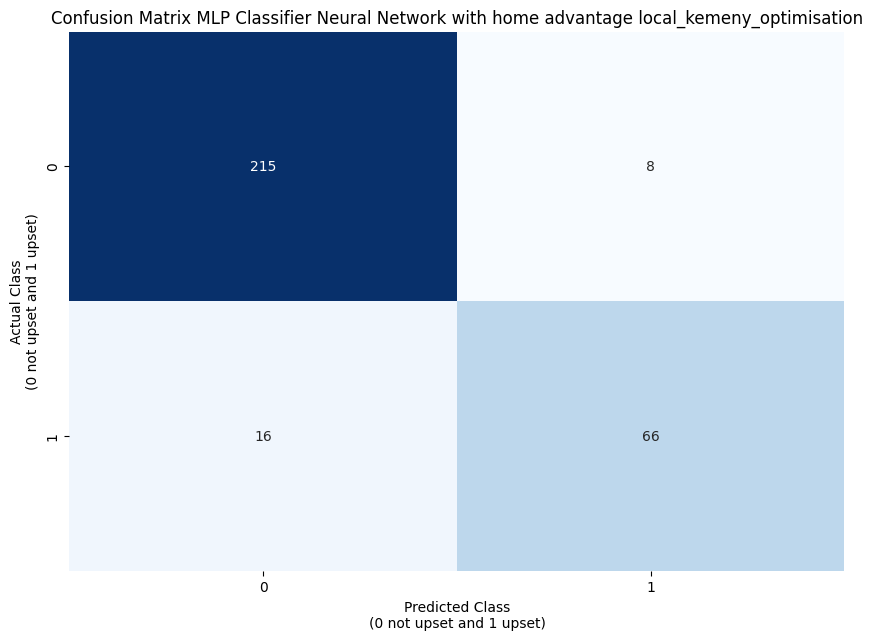

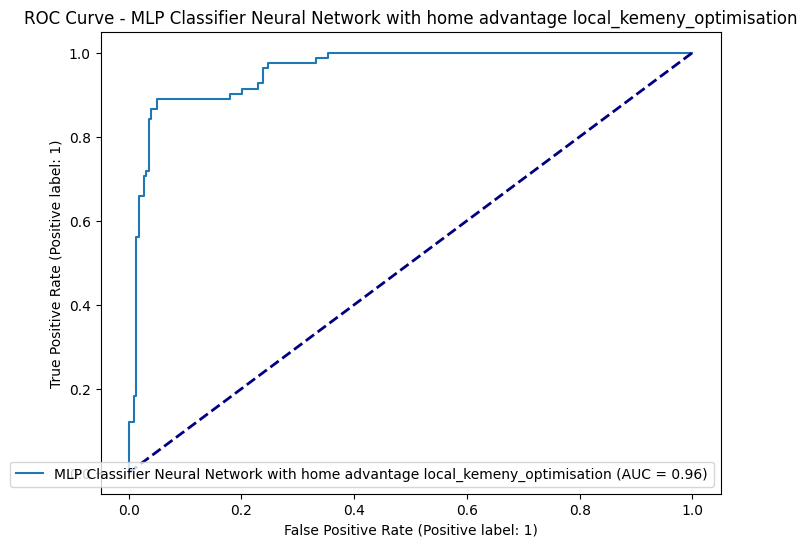

In [108]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nnh = all_results_df
display(all_results_df_nnh)

fold_results_df_nnh = fold_results_df
display(fold_results_df_nnh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nnh.to_excel("all_nnh_results.xlsx")
fold_results_df_nnh.to_excel("fold_results_nnh.xlsx")

Random Forest Classifier no_ranking
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.652
Fold 1 Accuracy: 0.803
Fold 1 Recall: 0.375
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.545
Fold 2 Accuracy: 0.951
Fold 2 Recall: 0.812
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 3 Accuracy: 0.836
Fold 3 Recall: 0.438
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.523
Fold 4 Accuracy: 0.984

,metric_id,metric,Random Forest Classifier no_ranking,Random Forest Classifier round_3_position,Random Forest Classifier massey,Random Forest Classifier colley,Random Forest Classifier keener,Random Forest Classifier trueskill,Random Forest Classifier borda_count,Random Forest Classifier local_kemeny_optimisation
0,1,Cross-validation Accuracy Mean,0.885,0.908,0.882,0.859,0.889,0.866,0.925,0.928
1,2,Cross-validation Accuracy Standard Deviation,0.070,0.058,0.028,0.068,0.038,0.054,0.052,0.048
2,3,Cross-validation Recall Mean,0.607,0.694,0.598,0.511,0.624,0.512,0.745,0.757
3,4,Cross-validation Recall Standard Deviation,0.070,0.058,0.028,0.068,0.038,0.054,0.052,0.048
4,5,Overall Accuracy,0.885,0.908,0.882,0.859,0.889,0.866,0.925,0.928
5,6,Confusion Matrix - True Negative (Class 0),220.000,220.000,220.000,220.000,220.000,222.000,221.000,221.000
6,7,Confusion Matrix - False Positive (Class 1),3.000,3.000,3.000,3.000,3.000,1.000,2.000,2.000
7,8,Confusion Matrix - False Negative (Class 0),32.000,25.000,33.000,40.000,31.000,40.000,21.000,20.000
8,9,Confusion Matrix - True Positive (Class 1),50.000,57.000,49.000,42.000,51.000,42.000,61.000,62.000
9,10,Precision (Class 0),0.873,0.898,0.870,0.846,0.876,0.847,0.913,0.917


,Model Name Ranking,Fold,Best Parameters (GridSearchCV),Best Recall (GridSearchCV),Validation Accuracy,Validation Recall
0,Random Forest Classifier no_ranking,1,"{'classifier__max_features': None, 'classifier...",0.651515,0.803279,0.375000
1,Random Forest Classifier no_ranking,2,"{'classifier__max_features': None, 'classifier...",0.545455,0.950820,0.812500
2,Random Forest Classifier no_ranking,3,"{'classifier__max_features': None, 'classifier...",0.590909,0.836066,0.437500
3,Random Forest Classifier no_ranking,4,"{'classifier__max_features': None, 'classifier...",0.523088,0.983607,0.941176
4,Random Forest Classifier no_ranking,5,"{'classifier__max_features': None, 'classifier...",0.617605,0.852459,0.470588
5,Random Forest Classifier round_3_position,1,"{'classifier__max_features': None, 'classifier...",0.681818,0.885246,0.625000
6,Random Forest Classifier round_3_position,2,"{'classifier__max_features': None, 'classifier...",0.575758,0.950820,0.812500
7,Random Forest Classifier round_3_position,3,"{'classifier__max_features': None, 'classifier...",0.590909,0.852459,0.562500
8,Random Forest Classifier round_3_position,4,"{'classifier__max_features': None, 'classifier...",0.555556,1.000000,1.000000
9,Random Forest Classifier round_3_position,5,"{'classifier__max_features': None, 'classifier...",0.491342,0.852459,0.470588


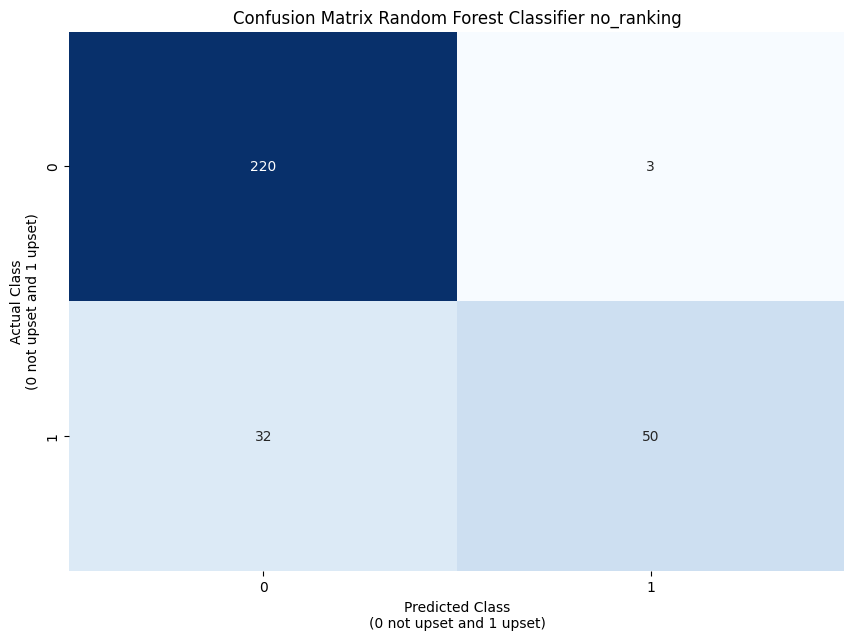

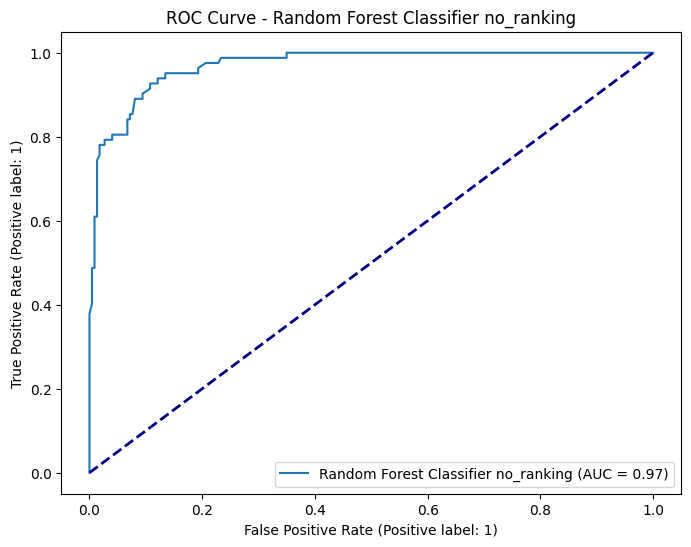

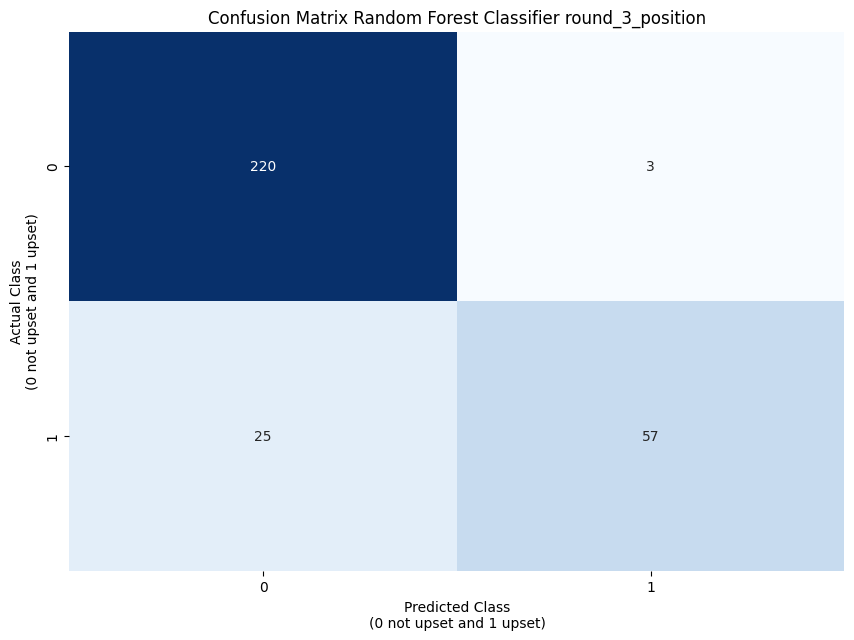

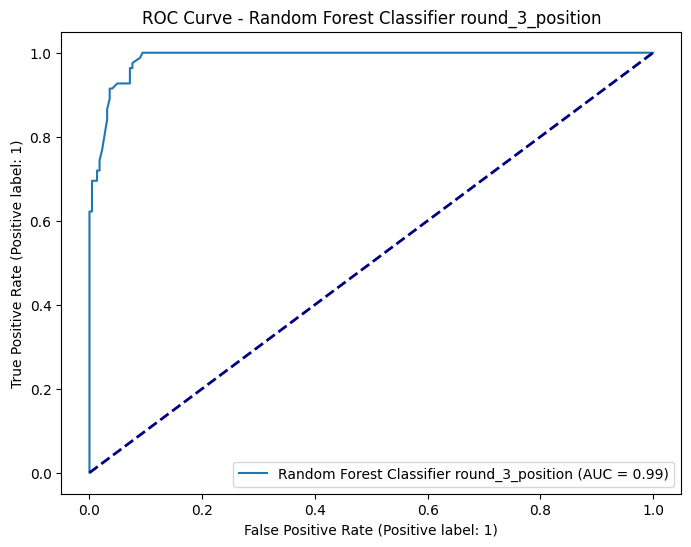

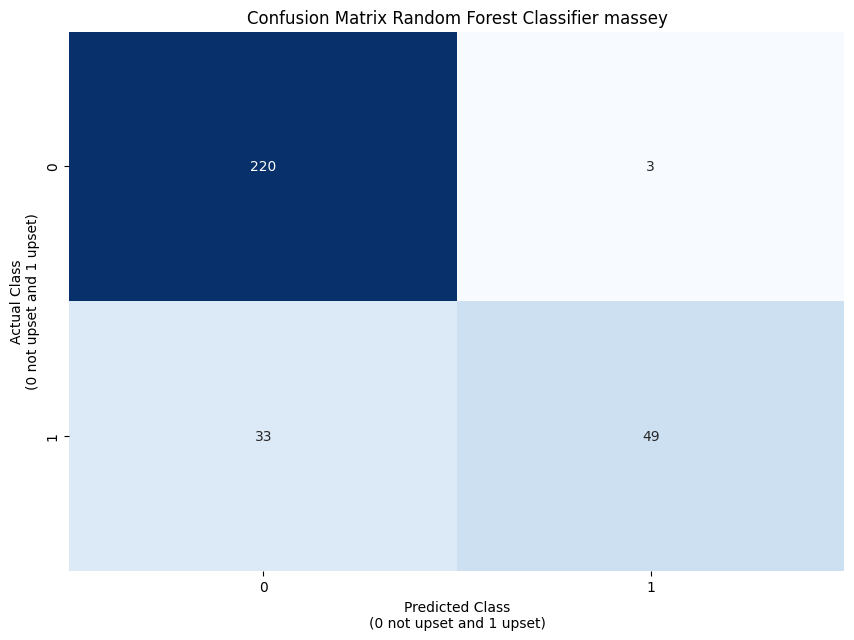

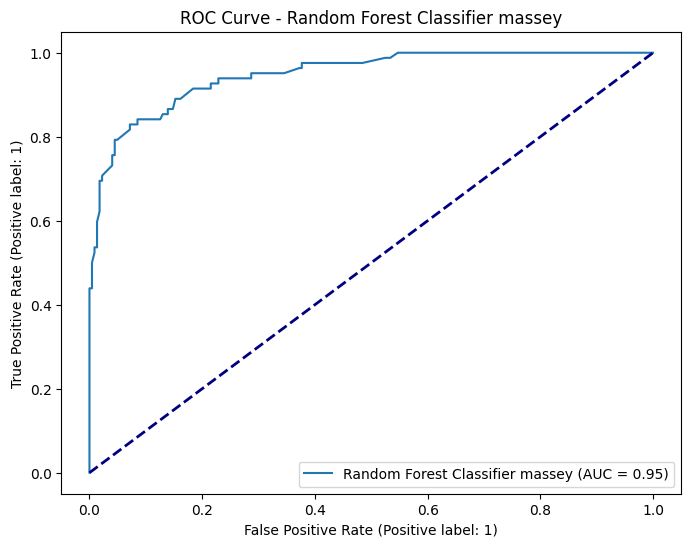

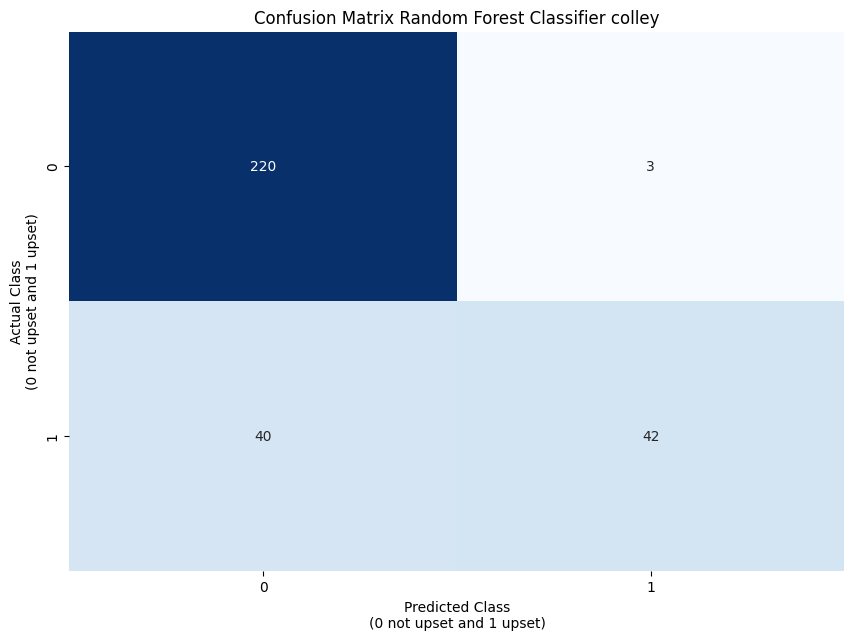

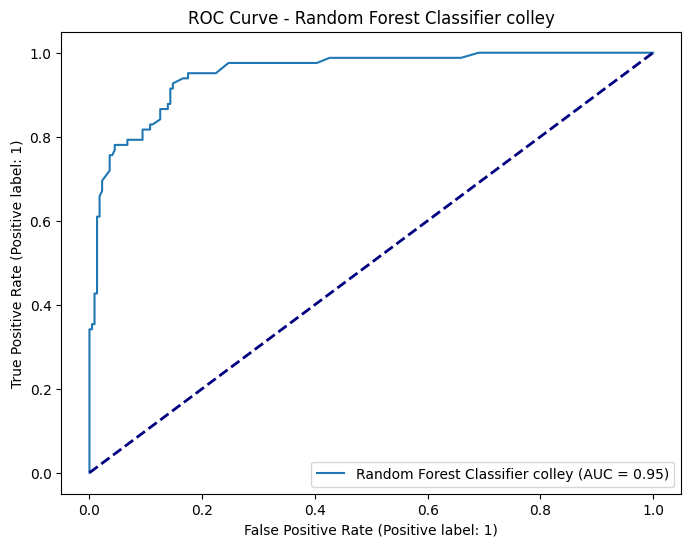

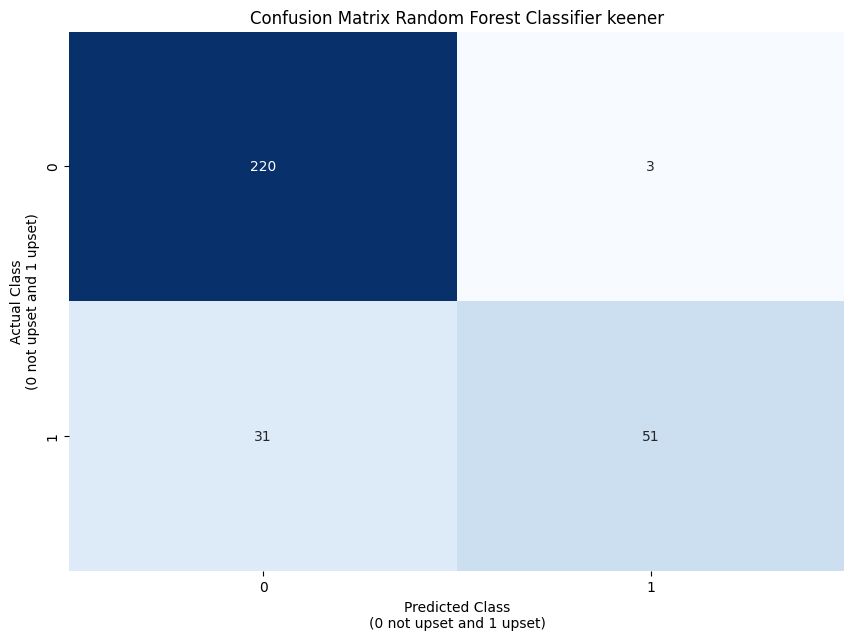

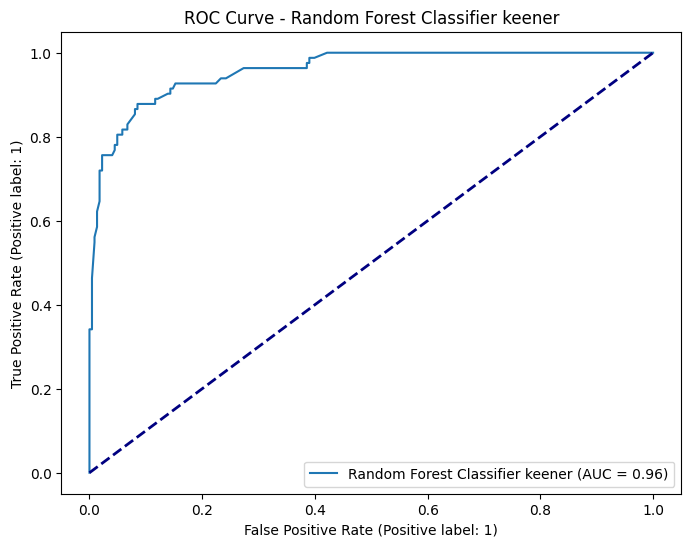

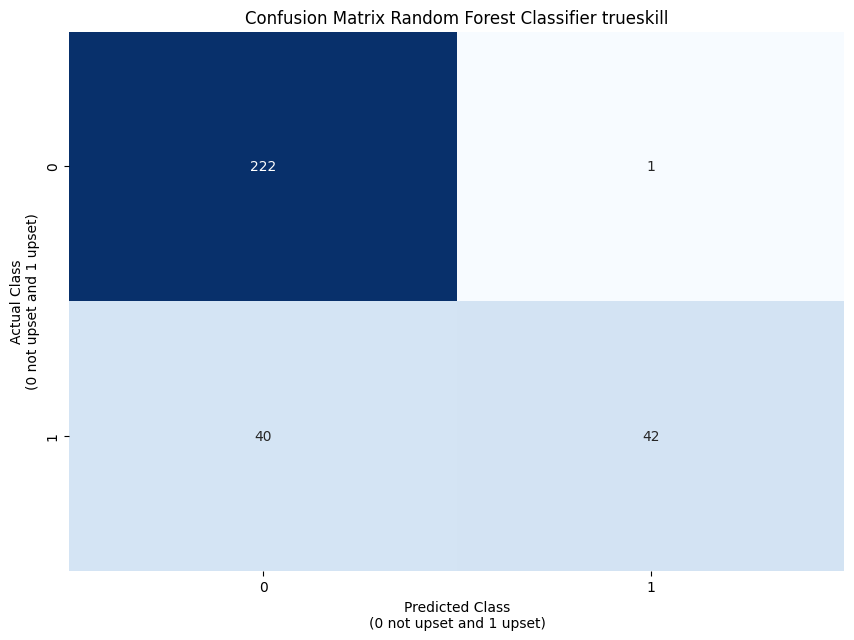

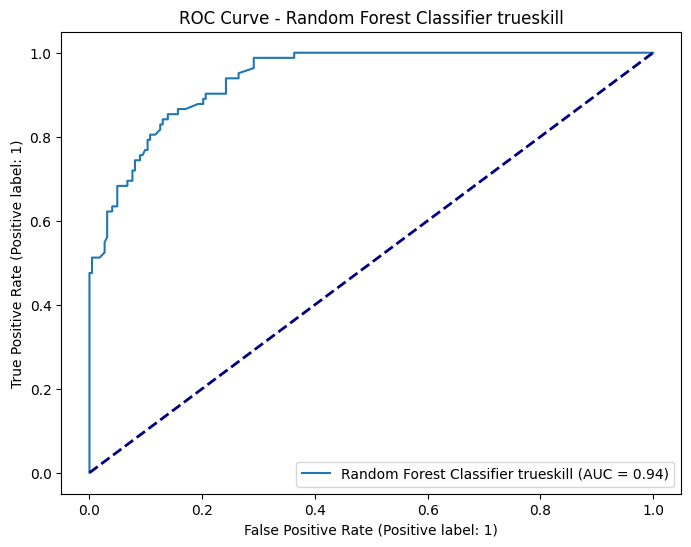

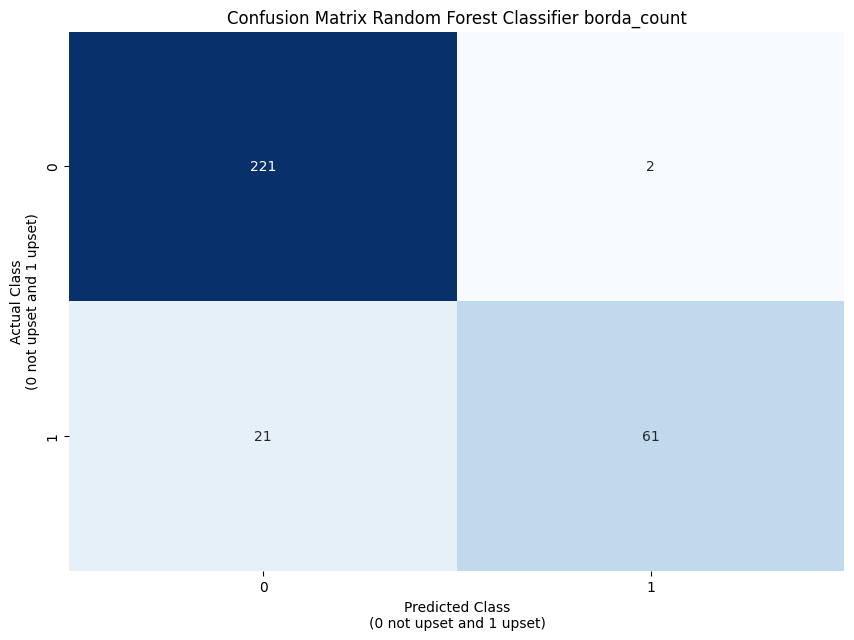

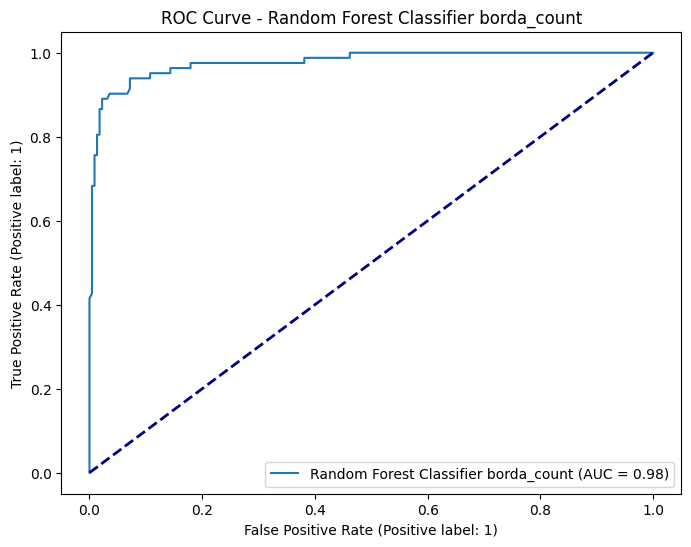

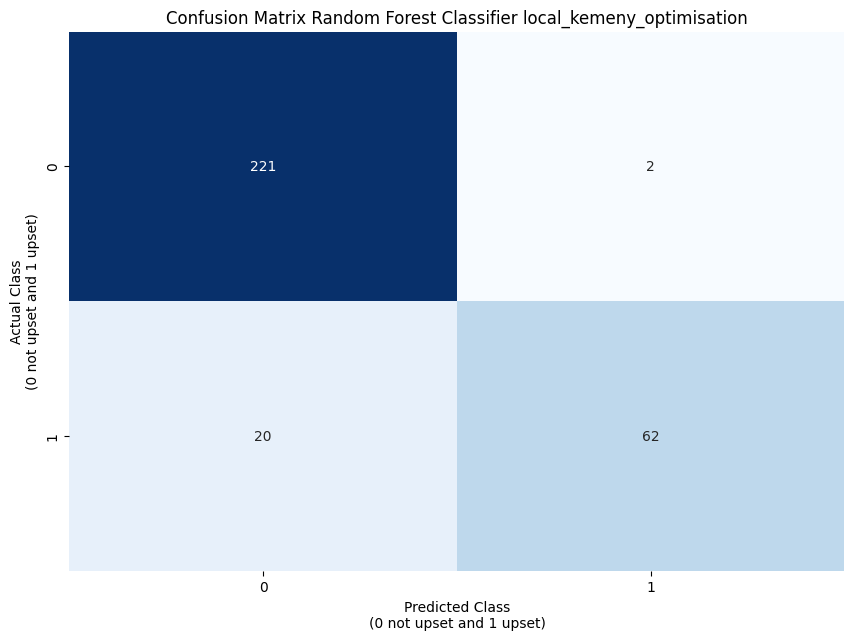

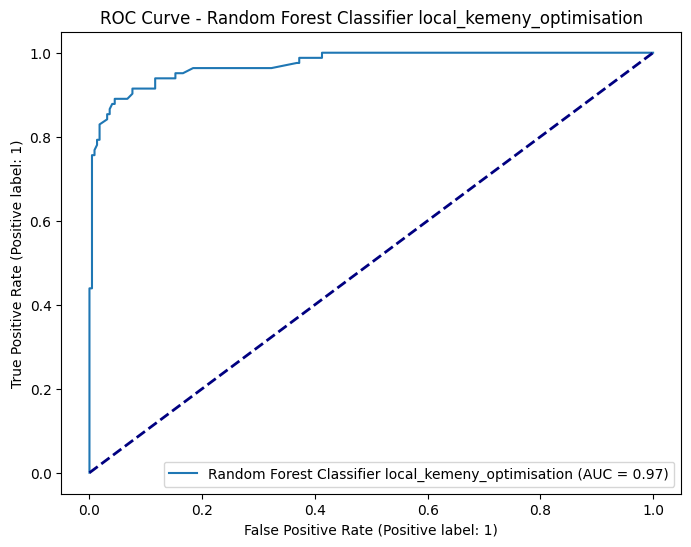

In [110]:
# Random Forest Classifier
model_name = "Random Forest Classifier"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rf = all_results_df
display(all_results_df_rf)

fold_results_df_rf = fold_results_df
display(fold_results_df_rf)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rf.to_excel("all_rf_results.xlsx")
fold_results_df_rf.to_excel("fold_results_rf.xlsx")


In [ ]:
# Random Forest Classifier with home advantage
model_name = "Random Forest Classifier with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rf = all_results_df
display(all_results_df_rf)

fold_results_df_rf = fold_results_df
display(fold_results_df_rf)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rf.to_excel("all_rf_results.xlsx")
fold_results_df_rf.to_excel("fold_results_rf.xlsx")

XG Boost no_ranking


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:56:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.818
Fold 1 Accuracy: 0.803
Fold 1 Recall: 0.250


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:57:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.697
Fold 2 Accuracy: 0.967
Fold 2 Recall: 1.000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:57:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.773
Fold 3 Accuracy: 0.918
Fold 3 Recall: 0.688


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:58:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.651
Fold 4 Accuracy: 0.984
Fold 4 Recall: 0.941


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:59:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.647
Fold 5 Accuracy: 0.803
Fold 5 Recall: 0.353
Average Accuracy: 0.895
Average Recall: 0.646
XG Boost round_3_position


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:00:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.712
Fold 1 Accuracy: 0.820
Fold 1 Recall: 0.312


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:00:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.621
Fold 2 Accuracy: 0.869
Fold 2 Recall: 0.625


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:01:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.652
Fold 3 Accuracy: 0.852
Fold 3 Recall: 0.562


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.603
Fold 4 Accuracy: 1.000
Fold 4 Recall: 1.000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:03:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.587
Fold 5 Accuracy: 0.902
Fold 5 Recall: 0.647
Average Accuracy: 0.889
Average Recall: 0.629
XG Boost massey


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:04:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.727
Fold 1 Accuracy: 0.902
Fold 1 Recall: 0.625


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:05:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.742
Fold 2 Accuracy: 0.852
Fold 2 Recall: 0.500


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:06:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.758
Fold 3 Accuracy: 0.820
Fold 3 Recall: 0.312


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:07:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.614
Fold 4 Accuracy: 0.869
Fold 4 Recall: 0.647


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:07:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.631
Fold 5 Accuracy: 0.885
Fold 5 Recall: 0.588
Average Accuracy: 0.866
Average Recall: 0.535
XG Boost colley


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:08:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.758
Fold 1 Accuracy: 0.902
Fold 1 Recall: 0.625


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:09:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.545
Fold 2 Accuracy: 0.852
Fold 2 Recall: 0.562


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:10:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.788
Fold 3 Accuracy: 0.918
Fold 3 Recall: 0.688


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:11:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.491
Fold 4 Accuracy: 0.885
Fold 4 Recall: 0.588


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:12:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.633
Fold 5 Accuracy: 0.852
Fold 5 Recall: 0.529
Average Accuracy: 0.882
Average Recall: 0.599
XG Boost keener


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:12:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.788
Fold 1 Accuracy: 0.869
Fold 1 Recall: 0.500


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:13:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.561
Fold 2 Accuracy: 0.885
Fold 2 Recall: 0.750


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:14:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.742
Fold 3 Accuracy: 0.836
Fold 3 Recall: 0.375


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.554
Fold 4 Accuracy: 0.934
Fold 4 Recall: 0.765


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:16:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.631
Fold 5 Accuracy: 0.820
Fold 5 Recall: 0.471
Average Accuracy: 0.869
Average Recall: 0.572
XG Boost trueskill


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.788
Fold 1 Accuracy: 0.820
Fold 1 Recall: 0.312


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.515
Fold 2 Accuracy: 0.836
Fold 2 Recall: 0.625


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:19:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.788
Fold 3 Accuracy: 0.885
Fold 3 Recall: 0.562


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:19:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.506
Fold 4 Accuracy: 0.902
Fold 4 Recall: 0.706


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:20:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.664
Fold 5 Accuracy: 0.803
Fold 5 Recall: 0.294
Average Accuracy: 0.849
Average Recall: 0.500
XG Boost borda_count


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:21:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.758
Fold 1 Accuracy: 0.803
Fold 1 Recall: 0.250


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:22:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 2 Accuracy: 0.918
Fold 2 Recall: 0.812


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:23:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.727
Fold 3 Accuracy: 0.820
Fold 3 Recall: 0.312


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:24:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.631
Fold 4 Accuracy: 0.984
Fold 4 Recall: 0.941


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:25:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.647
Fold 5 Accuracy: 0.836
Fold 5 Recall: 0.412
Average Accuracy: 0.872
Average Recall: 0.546
XG Boost local_kemeny_optimisation


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:26:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.758
Fold 1 Accuracy: 0.803
Fold 1 Recall: 0.250


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:27:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 2 Accuracy: 0.902
Fold 2 Recall: 0.750


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:27:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.727
Fold 3 Accuracy: 0.836
Fold 3 Recall: 0.375


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.646
Fold 4 Accuracy: 0.984
Fold 4 Recall: 0.941


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__sub_sample': 0.6}
Best Estimator's Recall (from GridSearchCV): 0.663
Fold 5 Accuracy: 0.836
Fold 5 Recall: 0.412
Average Accuracy: 0.872
Average Recall: 0.546


,metric_id,metric,XG Boost no_ranking,XG Boost round_3_position,XG Boost massey,XG Boost colley,XG Boost keener,XG Boost trueskill,XG Boost borda_count,XG Boost local_kemeny_optimisation
0,1,Cross-validation Accuracy Mean,0.895,0.889,0.866,0.882,0.869,0.849,0.872,0.872
1,2,Cross-validation Accuracy Standard Deviation,0.078,0.062,0.028,0.026,0.040,0.038,0.068,0.064
2,3,Cross-validation Recall Mean,0.646,0.629,0.535,0.599,0.572,0.500,0.546,0.546
3,4,Cross-validation Recall Standard Deviation,0.078,0.062,0.028,0.026,0.040,0.038,0.068,0.064
4,5,Overall Accuracy,0.895,0.889,0.866,0.882,0.869,0.849,0.872,0.872
5,6,Confusion Matrix - True Negative (Class 0),220.000,219.000,220.000,220.000,218.000,218.000,221.000,221.000
6,7,Confusion Matrix - False Positive (Class 1),3.000,4.000,3.000,3.000,5.000,5.000,2.000,2.000
7,8,Confusion Matrix - False Negative (Class 0),29.000,30.000,38.000,33.000,35.000,41.000,37.000,37.000
8,9,Confusion Matrix - True Positive (Class 1),53.000,52.000,44.000,49.000,47.000,41.000,45.000,45.000
9,10,Precision (Class 0),0.884,0.880,0.853,0.870,0.862,0.842,0.857,0.857


,Model Name Ranking,Fold,Best Parameters (GridSearchCV),Best Recall (GridSearchCV),Validation Accuracy,Validation Recall
0,XG Boost no_ranking,1,"{'classifier__colsample_bytree': 1.0, 'classif...",0.818182,0.803279,0.250000
1,XG Boost no_ranking,2,"{'classifier__colsample_bytree': 1.0, 'classif...",0.696970,0.967213,1.000000
2,XG Boost no_ranking,3,"{'classifier__colsample_bytree': 1.0, 'classif...",0.772727,0.918033,0.687500
3,XG Boost no_ranking,4,"{'classifier__colsample_bytree': 1.0, 'classif...",0.650794,0.983607,0.941176
4,XG Boost no_ranking,5,"{'classifier__colsample_bytree': 1.0, 'classif...",0.647186,0.803279,0.352941
5,XG Boost round_3_position,1,"{'classifier__colsample_bytree': 0.8, 'classif...",0.712121,0.819672,0.312500
6,XG Boost round_3_position,2,"{'classifier__colsample_bytree': 1.0, 'classif...",0.621212,0.868852,0.625000
7,XG Boost round_3_position,3,"{'classifier__colsample_bytree': 0.8, 'classif...",0.651515,0.852459,0.562500
8,XG Boost round_3_position,4,"{'classifier__colsample_bytree': 1.0, 'classif...",0.603175,1.000000,1.000000
9,XG Boost round_3_position,5,"{'classifier__colsample_bytree': 0.8, 'classif...",0.586580,0.901639,0.647059


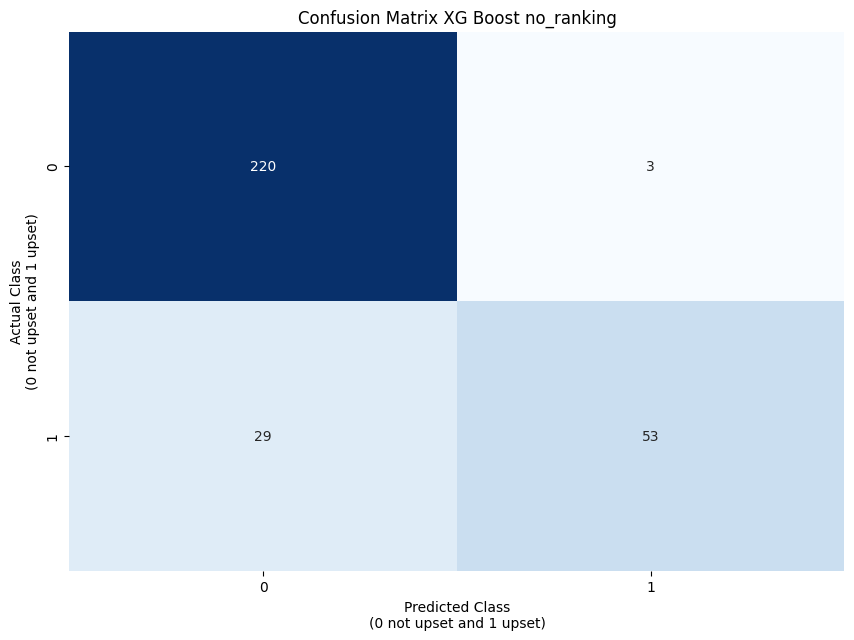

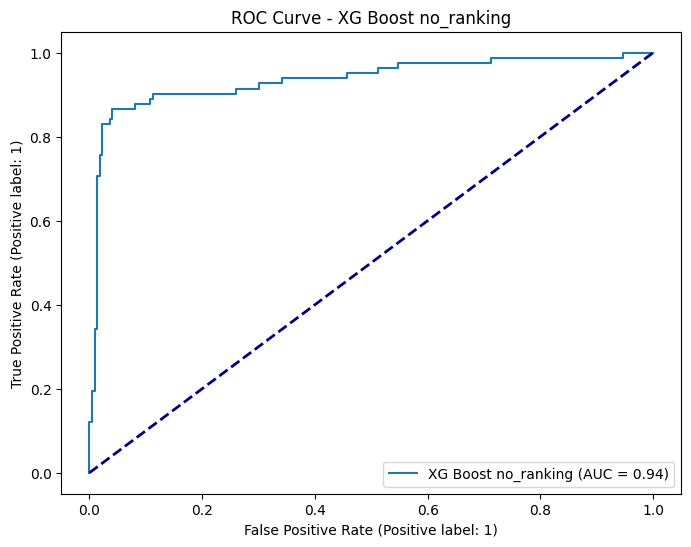

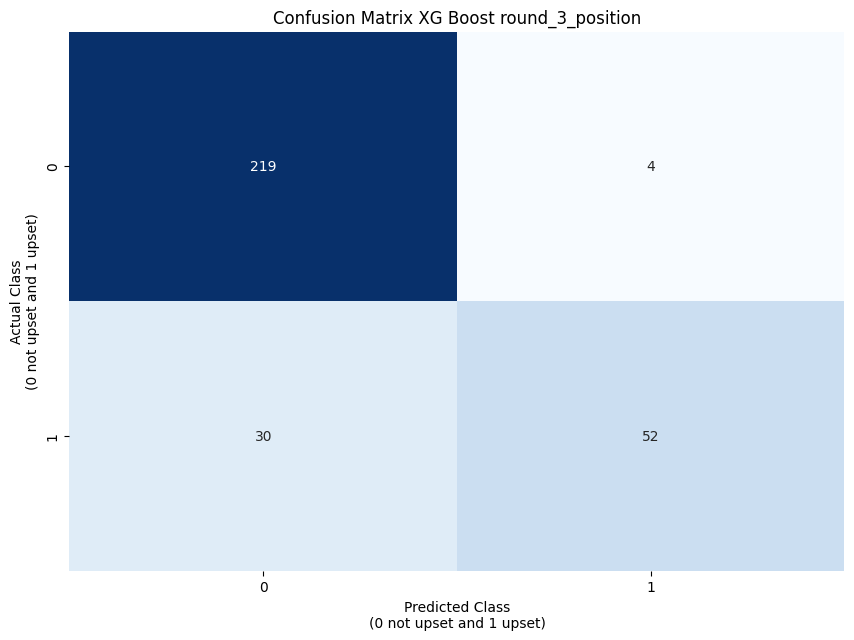

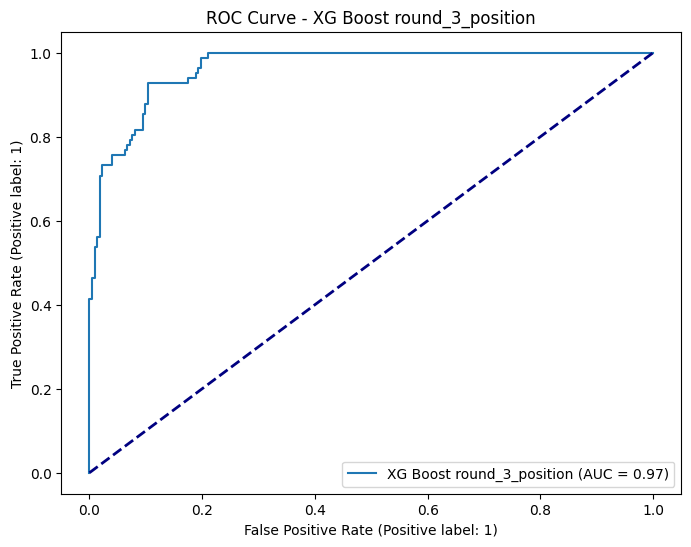

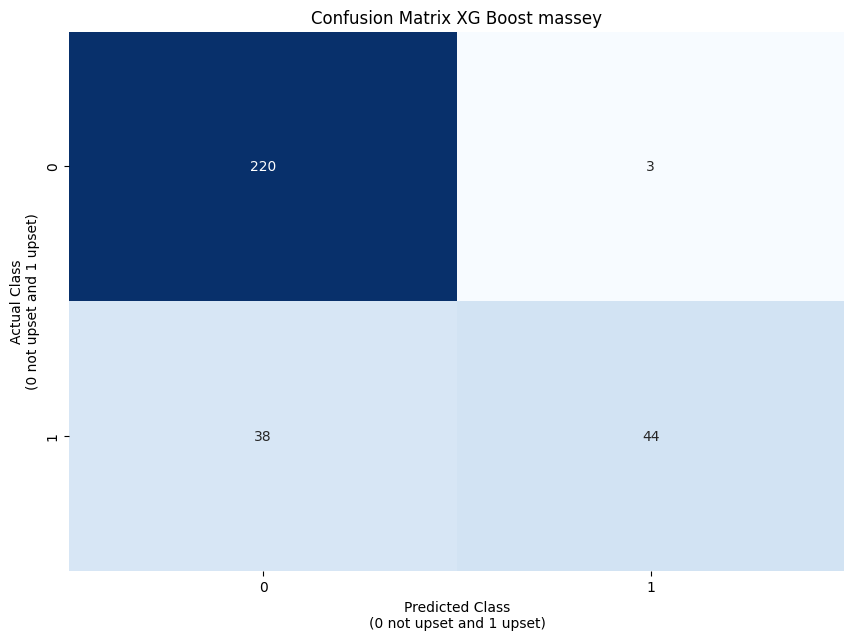

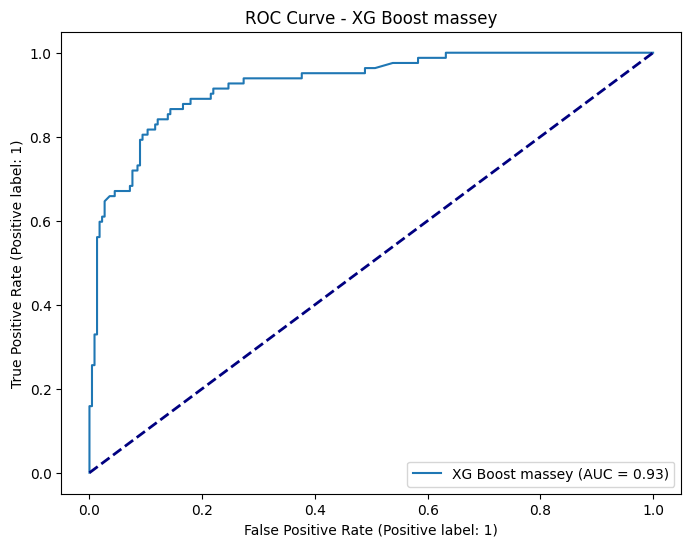

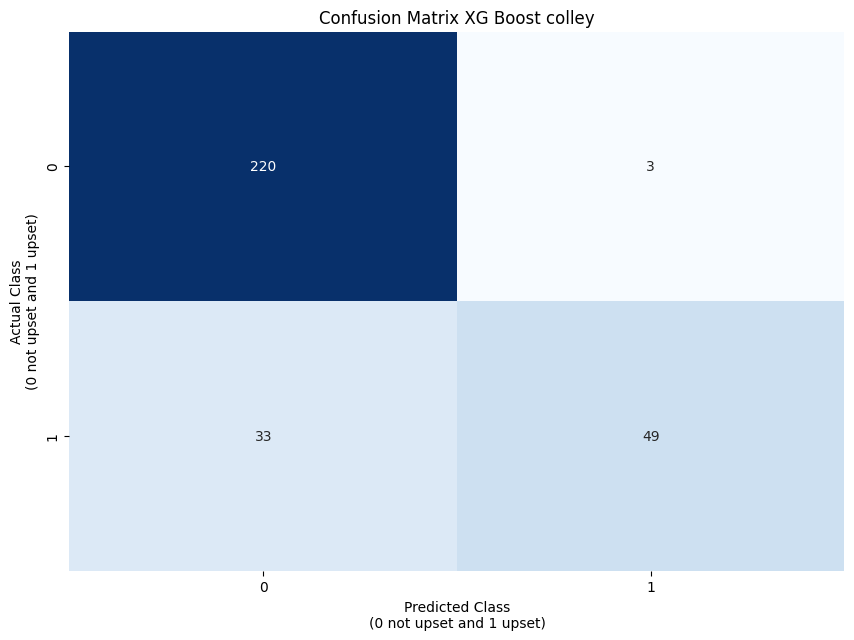

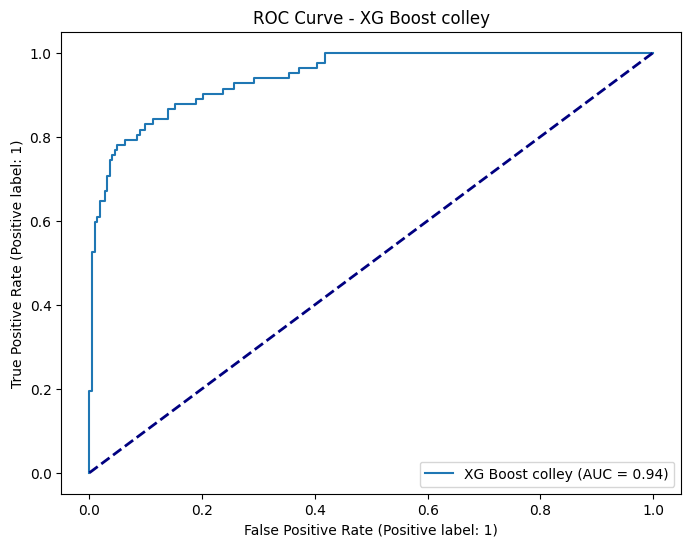

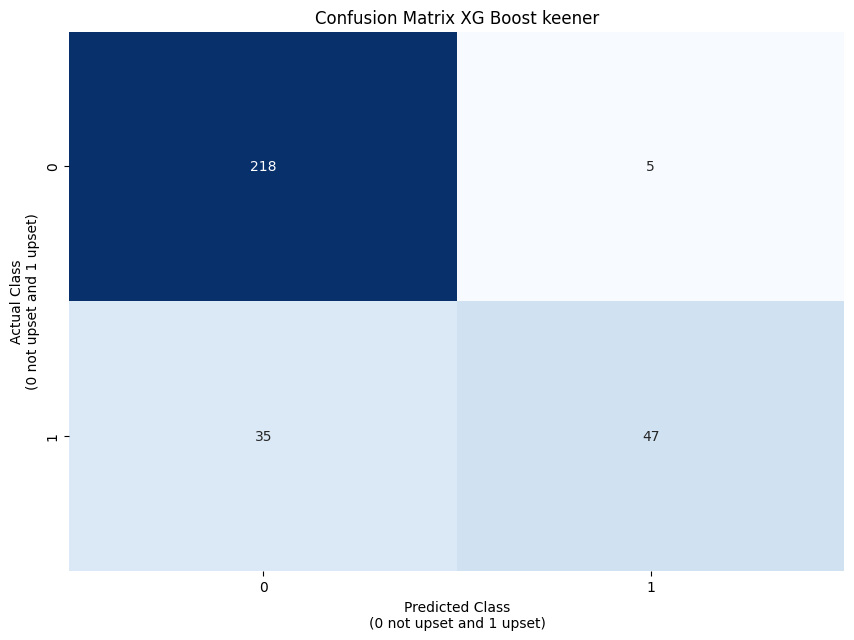

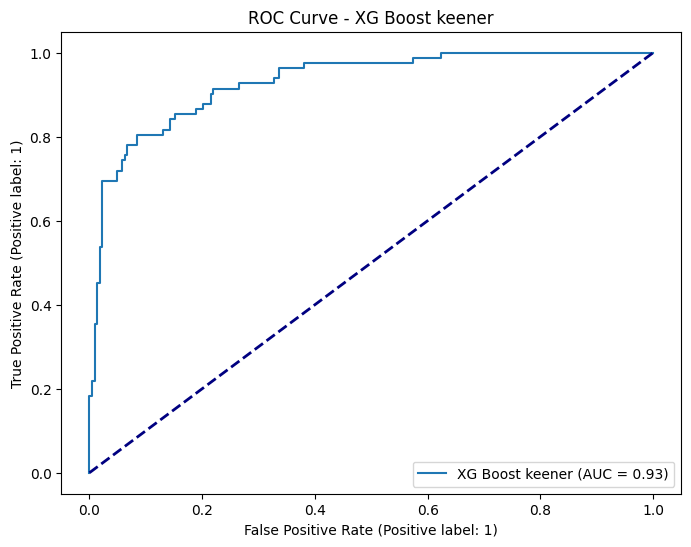

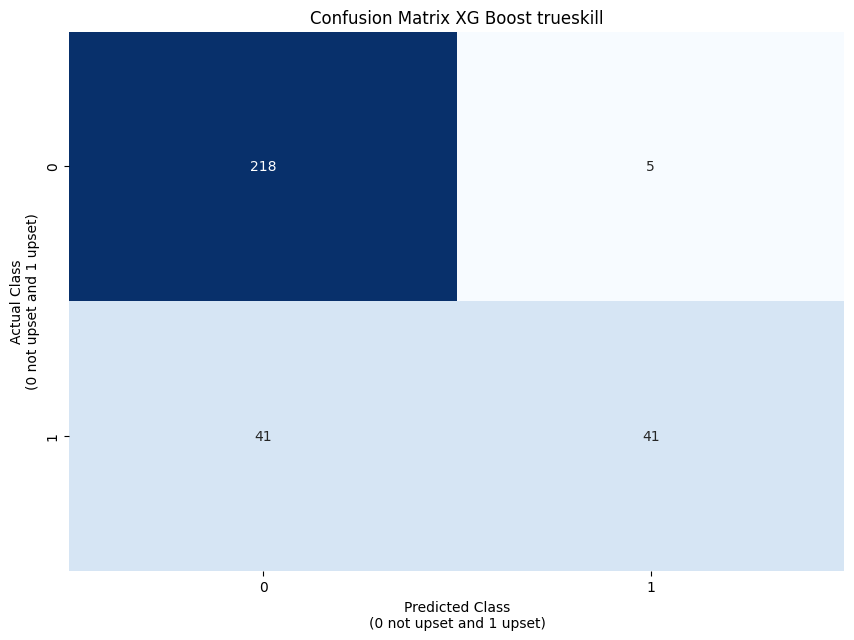

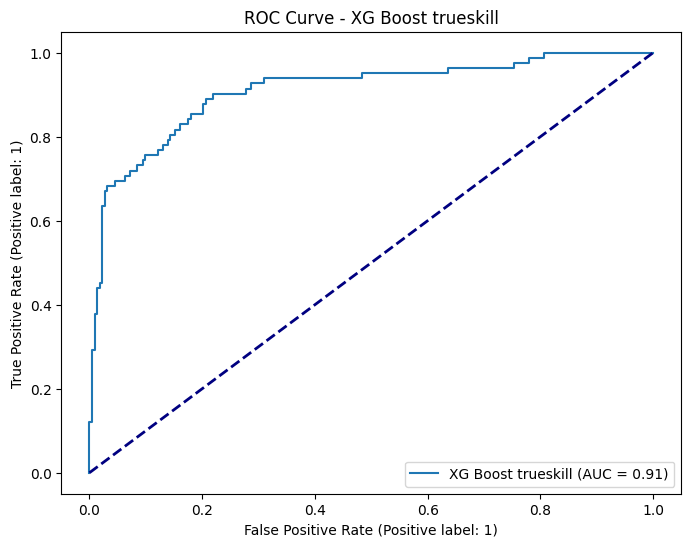

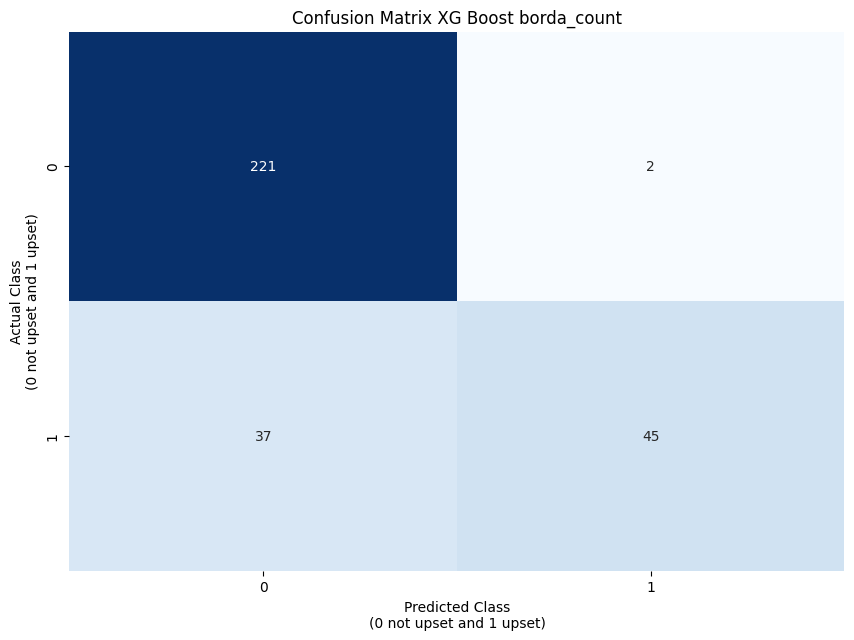

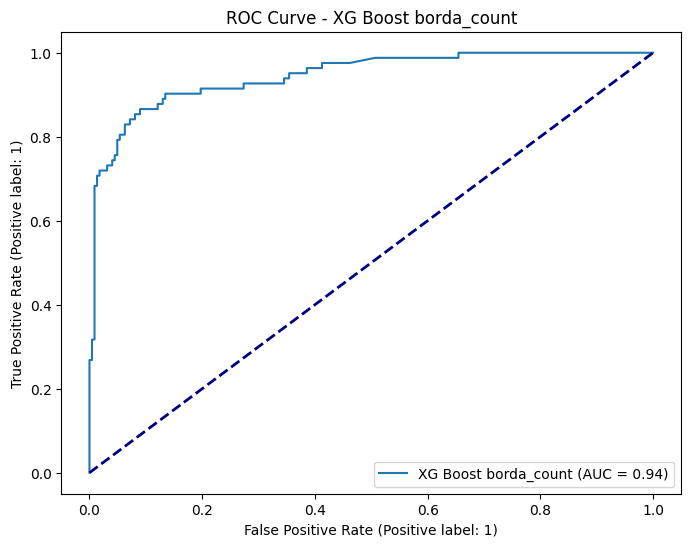

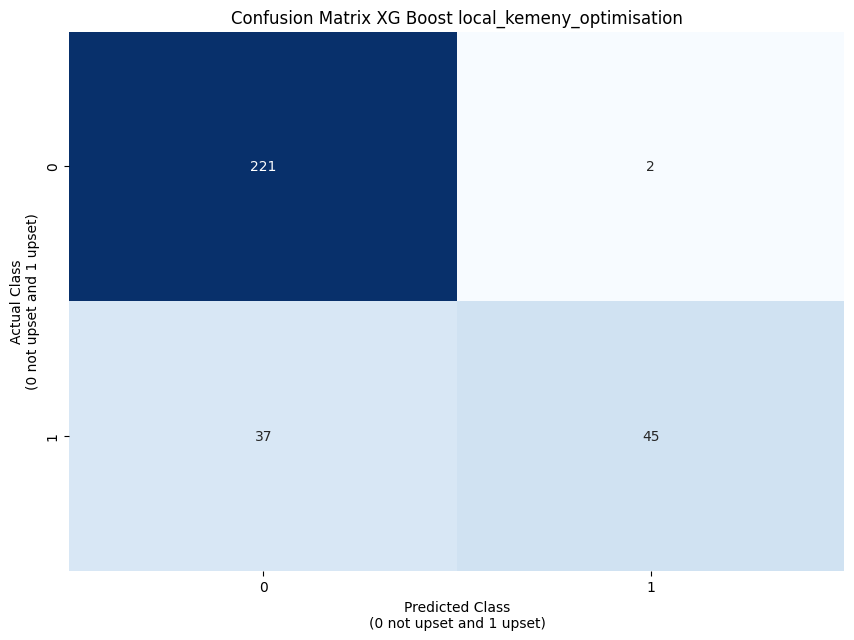

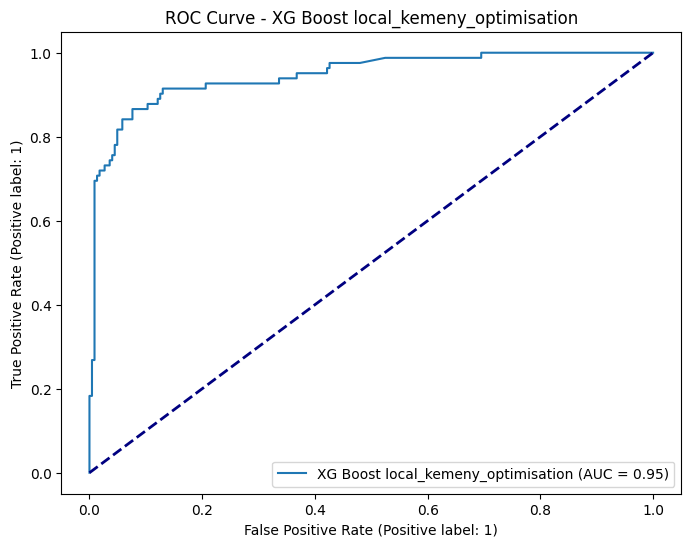

In [111]:
# XG Boost
model_name = "XG Boost"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xg = all_results_df
display(all_results_df_xg)

fold_results_df_xg = fold_results_df
display(fold_results_df_xg)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xg.to_excel("all_xg_results.xlsx")
fold_results_df_xg.to_excel("fold_results_xg.xlsx")

In [ ]:
# XG Boost with home advantage
model_name = "XG Boost with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xgh = all_results_df
display(all_results_df_xgh)

fold_results_df_xgh = fold_results_df
display(fold_results_df_xgh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xgh.to_excel("all_xgh_results.xlsx")
fold_results_df_xgh.to_excel("fold_results_xgh.xlsx")

In [115]:
all_results_df = all_results_df_slrh.merge(all_results_df_slr, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nn.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rf.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
#all_results_df = all_results_df_rfh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_xg.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
#all_results_df = all_results_df_xgh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

MergeError: Passing 'suffixes' which cause duplicate columns {'Weighted LogisticRegression no_ranking_x', 'Weighted LogisticRegression colley_x', 'Standard LogisticRegression local_kemeny_optimisation_x', 'Standard LogisticRegression massey_x', 'Weighted LogisticRegression keener_x', 'Weighted LogisticRegression borda_count_x', 'Weighted LogisticRegression local_kemeny_optimisation_x', 'Standard LogisticRegression keener_x', 'Standard LogisticRegression no_ranking_x', 'Standard LogisticRegression trueskill_x', 'Weighted LogisticRegression round_3_position_x', 'Standard LogisticRegression borda_count_x', 'Weighted LogisticRegression trueskill_x', 'Standard LogisticRegression colley_x', 'Standard LogisticRegression round_3_position_x', 'Weighted LogisticRegression massey_x'} is not allowed.

In [ ]:
# Load updated Confusion Matrix results to Google Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

In [112]:
fold_results_df = pd.concat([fold_results_df_slr, fold_results_df_slrh, fold_results_df_wlrh, fold_results_df_nn, fold_results_df_nnh, fold_results_df_rf, fold_results_df_rfh, fold_results_df_xg, fold_results_df_xgh])
display(fold_results_df)

,Model Name Ranking,Fold,Best Parameters (GridSearchCV),Best Recall (GridSearchCV),Validation Accuracy,Validation Recall
0,Standard LogisticRegression no_ranking,1,"{'classifier__C': 10.0, 'classifier__penalty':...",0.348485,0.704918,0.187500
1,Standard LogisticRegression no_ranking,2,"{'classifier__C': 1000.0, 'classifier__penalty...",0.393939,0.639344,0.250000
2,Standard LogisticRegression no_ranking,3,"{'classifier__C': 100.0, 'classifier__penalty'...",0.348485,0.639344,0.187500
3,Standard LogisticRegression no_ranking,4,"{'classifier__C': 10.0, 'classifier__penalty':...",0.411255,0.688525,0.117647
4,Standard LogisticRegression no_ranking,5,"{'classifier__C': 1000.0, 'classifier__penalty...",0.383117,0.721311,0.176471
...,...,...,...,...,...,...
35,MLP Classifier Neural Network with home advant...,1,"{'classifier__activation': 'relu', 'classifier...",0.636364,0.918033,0.812500
36,MLP Classifier Neural Network with home advant...,2,"{'classifier__activation': 'logistic', 'classi...",0.696970,0.983607,1.000000
37,MLP Classifier Neural Network with home advant...,3,"{'classifier__activation': 'logistic', 'classi...",0.636364,0.885246,0.750000
38,MLP Classifier Neural Network with home advant...,4,"{'classifier__activation': 'relu', 'classifier...",0.647908,0.950820,0.823529


In [ ]:
# Load updated Confusion Matrix results to Google Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_fold_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(fold_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')